# Step 1: Exploring Data

The purpose of this notebook is to do some basic data exploration. The goal is to better understand the data, so we can better create the training pipeline. This notebook attemps to answer questions such as how many unique models, how many unique vendors, missing data, correlation of the covariates and label, any intersting patterns in the SMART stats over time, etc.

In [1]:
import os
import gc
import utils
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

import pdb

In [2]:
pd.set_option("display.max_rows", 75)
pd.set_option("display.max_columns", 500)

In [3]:
pbar = ProgressBar()
pbar.register()

In [4]:
# inferred int32 types cause a type mismatch (int vs float) error when dask sees a null value
# null values cannot be interpreted as ints
custom_dtypes = {
    "date": "object",
    "serial_number": "object",
    "model": "object",
    "capacity_bytes": "float32",
    "failure": "float32",
    "smart_1_normalized": "float32",
    "smart_1_raw": "float32",
    "smart_2_normalized": "float32",
    "smart_2_raw": "float32",
    "smart_3_normalized": "float32",
    "smart_3_raw": "float32",
    "smart_4_normalized": "float32",
    "smart_4_raw": "float32",
    "smart_5_normalized": "float32",
    "smart_5_raw": "float32",
    "smart_7_normalized": "float32",
    "smart_7_raw": "float32",
    "smart_8_normalized": "float32",
    "smart_8_raw": "float32",
    "smart_9_normalized": "float32",
    "smart_9_raw": "float32",
    "smart_10_normalized": "float32",
    "smart_10_raw": "float32",
    "smart_11_normalized": "float32",
    "smart_11_raw": "float32",
    "smart_12_normalized": "float32",
    "smart_12_raw": "float32",
    "smart_13_normalized": "float32",
    "smart_13_raw": "float32",
    "smart_15_normalized": "float32",
    "smart_15_raw": "float32",
    "smart_16_normalized": "float32",
    "smart_16_raw": "float32",
    "smart_17_normalized": "float32",
    "smart_17_raw": "float32",
    "smart_22_normalized": "float32",
    "smart_22_raw": "float32",
    "smart_23_normalized": "float32",
    "smart_23_raw": "float32",
    "smart_24_normalized": "float32",
    "smart_24_raw": "float32",
    "smart_168_normalized": "float32",
    "smart_168_raw": "float32",
    "smart_170_normalized": "float32",
    "smart_170_raw": "float32",
    "smart_173_normalized": "float32",
    "smart_173_raw": "float32",
    "smart_174_normalized": "float32",
    "smart_174_raw": "float32",
    "smart_177_normalized": "float32",
    "smart_177_raw": "float32",
    "smart_179_normalized": "float32",
    "smart_179_raw": "float32",
    "smart_181_normalized": "float32",
    "smart_181_raw": "float32",
    "smart_182_normalized": "float32",
    "smart_182_raw": "float32",
    "smart_183_normalized": "float32",
    "smart_183_raw": "float32",
    "smart_184_normalized": "float32",
    "smart_184_raw": "float32",
    "smart_187_normalized": "float32",
    "smart_187_raw": "float32",
    "smart_188_normalized": "float32",
    "smart_188_raw": "float32",
    "smart_189_normalized": "float32",
    "smart_189_raw": "float32",
    "smart_190_normalized": "float32",
    "smart_190_raw": "float32",
    "smart_191_normalized": "float32",
    "smart_191_raw": "float32",
    "smart_192_normalized": "float32",
    "smart_192_raw": "float32",
    "smart_193_normalized": "float32",
    "smart_193_raw": "float32",
    "smart_194_normalized": "float32",
    "smart_194_raw": "float32",
    "smart_195_normalized": "float32",
    "smart_195_raw": "float32",
    "smart_196_normalized": "float32",
    "smart_196_raw": "float32",
    "smart_197_normalized": "float32",
    "smart_197_raw": "float32",
    "smart_198_normalized": "float32",
    "smart_198_raw": "float32",
    "smart_199_normalized": "float32",
    "smart_199_raw": "float32",
    "smart_200_normalized": "float32",
    "smart_200_raw": "float32",
    "smart_201_normalized": "float32",
    "smart_201_raw": "float32",
    "smart_218_normalized": "float32",
    "smart_218_raw": "float32",
    "smart_220_normalized": "float32",
    "smart_220_raw": "float32",
    "smart_222_normalized": "float32",
    "smart_222_raw": "float32",
    "smart_223_normalized": "float32",
    "smart_223_raw": "float32",
    "smart_224_normalized": "float32",
    "smart_224_raw": "float32",
    "smart_225_normalized": "float32",
    "smart_225_raw": "float32",
    "smart_226_normalized": "float32",
    "smart_226_raw": "float32",
    "smart_231_normalized": "float32",
    "smart_231_raw": "float32",
    "smart_232_normalized": "float32",
    "smart_232_raw": "float32",
    "smart_233_normalized": "float32",
    "smart_233_raw": "float32",
    "smart_235_normalized": "float32",
    "smart_235_raw": "float32",
    "smart_240_normalized": "float32",
    "smart_240_raw": "float32",
    "smart_241_normalized": "float32",
    "smart_241_raw": "float32",
    "smart_242_normalized": "float32",
    "smart_242_raw": "float32",
    "smart_250_normalized": "float32",
    "smart_250_raw": "float32",
    "smart_251_normalized": "float32",
    "smart_251_raw": "float32",
    "smart_252_normalized": "float32",
    "smart_252_raw": "float32",
    "smart_254_normalized": "float32",
    "smart_254_raw": "float32",
    "smart_255_normalized": "float32",
    "smart_255_raw": "float32",
}

In [5]:
# read all the (local) data into one dataframe
DATA_ROOT_DIR = '/home/kachauha/Downloads/'
df4 = dd.read_parquet(os.path.join(DATA_ROOT_DIR, 'data_Q4_2018_parquet'), engine='pyarrow', index=False)
df3 = dd.read_parquet(os.path.join(DATA_ROOT_DIR, 'data_Q3_2018_parquet'), engine='pyarrow', index=False)
df2 = dd.read_parquet(os.path.join(DATA_ROOT_DIR, 'data_Q2_2018_parquet'), engine='pyarrow', index=False)
df1 = dd.read_parquet(os.path.join(DATA_ROOT_DIR, 'data_Q1_2018_parquet'), engine='pyarrow', index=False)
df = utils.optimal_repartition_df(dd.concat(dfs=[df1, df2, df3, df4], interleave_partitions=True))

[########################################] | 100% Completed |  1min 32.4s


In [6]:
# split into working vs failed drives serial number
failed_sers = df[df['failure']==1][['serial_number', 'model']].compute()
working_sers = df[~df['serial_number'].isin(failed_sers['serial_number'])][['serial_number', 'model']].drop_duplicates().compute()

# sanity check - make sure we havent labelled a serial number as BOTH working and failed
assert ~working_sers['serial_number'].isin(failed_sers['serial_number']).any()

# how many of each class
print(f'{len(failed_sers)} failed drives, {len(working_sers)} working drives')

[########################################] | 100% Completed | 34.3s
[########################################] | 100% Completed | 52.2s
1381 failed drives, 122948 working drives


## Manufacturer-level and Model-level analysis
The values of SMART stats and whether or not they are reported varies from vendor to vendor. Furthermore, simply including vendor as a feature may or may not work for all kinds of prediction models. Therefore, it may be a good idea to analyze the data in a vendor specific way.

In [7]:
# split data into vendors, print how many data points available for each vendor
seagate_df = df[df['model'].str.startswith('S')]
print(dd.compute(seagate_df.shape))
hgst_df = df[df['model'].str.startswith('HG')]
print(dd.compute(hgst_df.shape))
toshiba_df = df[df['model'].str.startswith('T')]
print(dd.compute(toshiba_df.shape))
wdc_df = df[df['model'].str.startswith('W')]
print(dd.compute(wdc_df.shape))
hitachi_df = df[df['model'].str.startswith('Hi')]
print(dd.compute(hitachi_df.shape))

[########################################] | 100% Completed | 46.9s
((28004260, 129),)
[########################################] | 100% Completed | 44.2s
((7741899, 129),)
[########################################] | 100% Completed | 43.0s
((482251, 129),)
[########################################] | 100% Completed | 42.9s
((348371, 129),)
[########################################] | 100% Completed | 41.8s
((123725, 129),)


The cell below determines how big of a chunk of the total dataset does each hard drive model comprise. Also, what percent of that model failed.

In [30]:
# how many drives by model, and what is the fail percentage
model_stats = pd.merge(failed_sers['model'].value_counts().to_frame('failed_count').reset_index(),
                        working_sers['model'].value_counts().to_frame('working_count').reset_index(),
                        how='outer').fillna(0)

# rename the index column as the model column
model_stats.rename(columns={'index': 'model'}, inplace=True)

# total count of model, raw value and as a percent of total drives
model_stats['total_count'] = model_stats['failed_count'] + model_stats['working_count']
model_stats['total_percent'] = np.around(100 * model_stats['total_count'] / model_stats['total_count'].sum(), decimals=2) 

# percentage of instances that have failed, per model
model_stats['fail_percent'] = np.around(100 * model_stats['failed_count'] / model_stats['total_count'], decimals=2)

# add manufacturer/vendor column
model_stats['vendor'] = model_stats['model'].apply(utils.get_vendor)

model_stats.sort_values(by=['total_count'], ascending=False)

,model,failed_count,working_count,total_count,total_percent,fail_percent,vendor
1,ST12000NM0007,297.0,32341.0,32638.0,26.25,0.91,Seagate
0,ST4000DM000,581.0,31583.0,32164.0,25.87,1.81,Seagate
4,HGST HMS5C4040BLE640,54.0,15328.0,15382.0,12.37,0.35,HGST
2,ST8000NM0055,126.0,14383.0,14509.0,11.67,0.87,Seagate
3,ST8000DM002,92.0,9873.0,9965.0,8.02,0.92,Seagate
7,HGST HMS5C4040ALE640,24.0,6531.0,6555.0,5.27,0.37,HGST
31,Hitachi HDS5C4040ALE630,0.0,2296.0,2296.0,1.85,0.00,Hitachi
8,ST6000DX000,17.0,1865.0,1882.0,1.51,0.90,Seagate
12,TOSHIBA MG07ACA14TA,9.0,1270.0,1279.0,1.03,0.70,Toshiba
28,HGST HUH721212ALN604,1.0,1278.0,1279.0,1.03,0.08,HGST


**NOTE**: Although there are 48 different models of hard drives being used, these are coming from only 5 unique vendors.

The cell below tries to find if the fail/work ratio is greater in some manufacturers than others. It also gives an idea of how much data do we have from each manufacturer.

In [8]:
# how many failed drives in each vendor
for mdf in (seagate_df, hgst_df, toshiba_df, wdc_df, hitachi_df):
    num_failed_sers = (mdf['failure']==1).sum().compute()
    num_working_sers = mdf['serial_number'].nunique().compute() - num_failed_sers
    print('{} failed drives\n{} working drives'.format(num_failed_sers, num_working_sers))
    print('================================================================================')

[########################################] | 100% Completed | 46.3s
[########################################] | 100% Completed | 53.0s
1189 failed drives
92739 working drives
[########################################] | 100% Completed | 44.4s
[########################################] | 100% Completed | 45.8s
89 failed drives
24327 working drives
[########################################] | 100% Completed | 42.6s
[########################################] | 100% Completed | 42.5s
66 failed drives
2389 working drives
[########################################] | 100% Completed | 42.6s
[########################################] | 100% Completed | 42.4s
31 failed drives
1088 working drives
[########################################] | 100% Completed | 42.3s
[########################################] | 100% Completed | 42.2s
6 failed drives
2402 working drives


In [24]:
# get vendor-wise stats for failed vs working
vendor_stats = model_stats.groupby('vendor').sum()
vendor_stats['fail_percent'] = np.around(100 * vendor_stats['failed_count'] / (vendor_stats['failed_count'] + vendor_stats['working_count']), decimals=2)
vendor_stats

,failed_count,working_count,total_count,total_percent,fail_percent
vendor,,,,,
HGST,89.0,24327.0,24416.0,19.64,0.36
Hitachi,6.0,2402.0,2408.0,1.94,0.25
Seagate,1189.0,92741.0,93930.0,75.55,1.27
Toshiba,66.0,2390.0,2456.0,1.99,2.69
WDC,31.0,1088.0,1119.0,0.89,2.77


[########################################] | 100% Completed | 50.9s


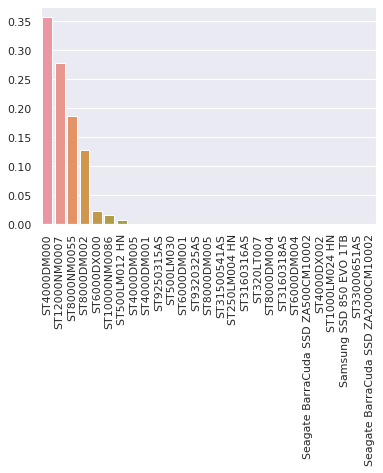

[########################################] | 100% Completed | 44.6s


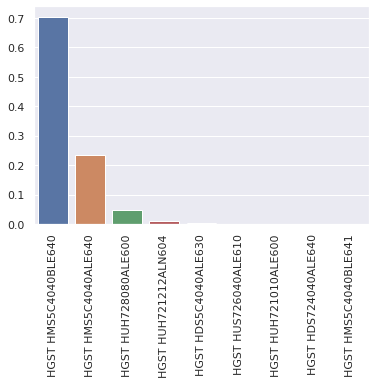

[########################################] | 100% Completed | 44.0s


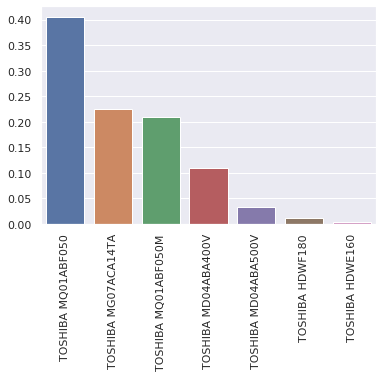

[########################################] | 100% Completed | 47.4s


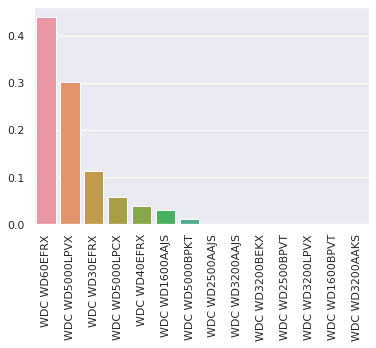

[########################################] | 100% Completed | 46.2s


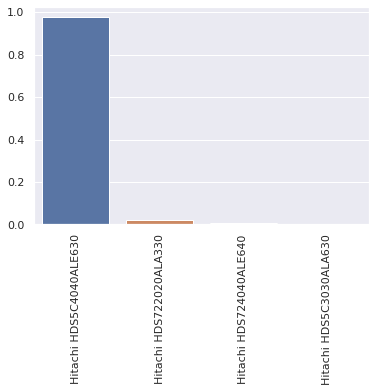

In [21]:
# within drives of a manufacturer, what is the distribution of models like
for mdf in (seagate_df, hgst_df, toshiba_df, wdc_df, hitachi_df):
    valcts = mdf['model'].value_counts().compute()
    sns.barplot(x=valcts.index, y=(valcts.values / valcts.sum()))
    plt.xticks(rotation=90)
    plt.show()

**NOTE**: From the above barplots, it can be seen that only a few models comprise a huge chunk of all the data from a manufacturer

## Analyze Critical Stats

These are the columns specified by wikipedia, backblaze, and IBM research as good predictors.

1. Backblaze mentions five stats as better predictors than others. These are 5, 187, 188, 197, 198.They also provide some [analysis](https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/) using these features.

2. IBM published a [paper](https://www.kdd.org/kdd2016/papers/files/adf0849-botezatuA.pdf) regarding drive failure prediction as well.

3. Wikipedia also [mentions](https://en.wikipedia.org/wiki/S.M.A.R.T.#ATA_S.M.A.R.T._attributes) some predictors as critical.

In [31]:
CRITICAL_STATS = [1, 5, 7, 10, 184, 187, 188, 189, 190, 193, 194, 196, 197, 198, 201, 240, 241, 242]

# NOTE - THESE LISTS ARE SUBJECT TO CHANGE
crit_cols_raw = ['smart_{}_raw'.format(i) for i in CRITICAL_STATS]
crit_cols_normalized = ['smart_{}_normalized'.format(i) for i in CRITICAL_STATS]

### SMART Stats Descriptions
Source: Wikipedia

Putting descriptions here to help better make sense of the results that follow.

184 = end to end error / ioedc : This attribute is a part of Hewlett-Packard's SMART IV technology, as well as part of other vendors' IO Error Detection and Correction schemas, and it contains a count of parity errors which occur in the data path to the media via the drive's cache RAM.

187 = reported uncorrectable errors : The count of errors that could not be recovered using hardware ECC (see attribute 195)

188 = command timeout : The count of aborted operations due to HDD timeout. Normally this attribute value should be equal to zero.

189 = high fly write : This feature is implemented in most modern Seagate drives and some of Western Digital's drives, beginning with the WD Enterprise WDE18300 and WDE9180 Ultra2 SCSI hard drives, and will be included on all future WD Enterprise products.

190 = temp diff / airflow diff : Value is equal to (100-temp. °C), allowing manufacturer to set a minimum threshold which corresponds to a maximum temperature. This also follows the convention of 100 being a best-case value and lower values being undesirable. However, some older drives may instead report raw Temperature (identical to 0xC2) or Temperature minus 50 here.

196 = reallocation event count : Count of remap operations. The raw value of this attribute shows the total count of attempts to transfer data from reallocated sectors to a spare area. Both successful and unsuccessful attempts are counted

201 = soft read eror rate or TA counter detected : Count indicates the number of uncorrectable software read errors.

### NaN Counts

In [33]:
# number of nans
print('All data')
nan_count = utils.get_nan_count_percent(df[crit_cols_raw + crit_cols_normalized]).compute()
nan_count

All data
[########################################] | 100% Completed | 37.9s
[########################################] | 100% Completed | 36.4s


,count,percent
smart_1_raw,1069,0.000029
smart_5_raw,1335,0.000036
smart_7_raw,1569,0.000043
smart_10_raw,1569,0.000043
smart_184_raw,16714033,0.455417
smart_187_raw,8930415,0.243332
smart_188_raw,8930649,0.243339
smart_189_raw,16714033,0.455417
smart_190_raw,8930415,0.243332
smart_193_raw,240980,0.006566


Some vendors may not provide certain SMART stats. This could be one possible explanation for the high number of nans. If this is the case, then that particular feature will not be helpful for predicting status of a drive from that vendor. Lets get the vendor-wise nans

In [34]:
print('Seagate')
seagate_nan_ct = utils.get_nan_count_percent(seagate_df[crit_cols_raw + crit_cols_normalized]).compute()
seagate_nan_ct

Seagate
[########################################] | 100% Completed | 47.7s
[########################################] | 100% Completed | 48.2s


,count,percent
smart_1_raw,970,0.000035
smart_5_raw,1236,0.000044
smart_7_raw,1470,0.000052
smart_10_raw,1470,0.000052
smart_184_raw,8017787,0.286306
smart_187_raw,234169,0.008362
smart_188_raw,234403,0.008370
smart_189_raw,8017787,0.286306
smart_190_raw,234169,0.008362
smart_193_raw,240881,0.008602


In [35]:
print('WDC')
wdc_nan_ct = utils.get_nan_count_percent(wdc_df[crit_cols_raw + crit_cols_normalized]).compute()
wdc_nan_ct

WDC
[########################################] | 100% Completed | 43.3s
[########################################] | 100% Completed | 43.4s


,count,percent
smart_1_raw,0,0.000000
smart_5_raw,0,0.000000
smart_7_raw,0,0.000000
smart_10_raw,0,0.000000
smart_184_raw,348371,1.000000
smart_187_raw,348371,1.000000
smart_188_raw,348371,1.000000
smart_189_raw,348371,1.000000
smart_190_raw,348371,1.000000
smart_193_raw,0,0.000000


In [36]:
print('HGST')
hgst_nan_ct = utils.get_nan_count_percent(hgst_df[crit_cols_raw + crit_cols_normalized]).compute()
hgst_nan_ct

HGST
[########################################] | 100% Completed | 46.6s
[########################################] | 100% Completed | 47.2s


,count,percent
smart_1_raw,94,0.000012
smart_5_raw,94,0.000012
smart_7_raw,94,0.000012
smart_10_raw,94,0.000012
smart_184_raw,7741899,1.000000
smart_187_raw,7741899,1.000000
smart_188_raw,7741899,1.000000
smart_189_raw,7741899,1.000000
smart_190_raw,7741899,1.000000
smart_193_raw,94,0.000012


In [37]:
print('Hitachi')
hitachi_nan_ct = utils.get_nan_count_percent(hitachi_df[crit_cols_raw + crit_cols_normalized]).compute()
hitachi_nan_ct

Hitachi
[########################################] | 100% Completed | 43.4s
[########################################] | 100% Completed | 42.9s


,count,percent
smart_1_raw,0,0.0
smart_5_raw,0,0.0
smart_7_raw,0,0.0
smart_10_raw,0,0.0
smart_184_raw,123725,1.0
smart_187_raw,123725,1.0
smart_188_raw,123725,1.0
smart_189_raw,123725,1.0
smart_190_raw,123725,1.0
smart_193_raw,0,0.0


In [38]:
print('Toshiba')
toshiba_nan_ct = utils.get_nan_count_percent(toshiba_df[crit_cols_raw + crit_cols_normalized]).compute()
toshiba_nan_ct

Toshiba
[########################################] | 100% Completed | 43.8s
[########################################] | 100% Completed | 46.3s


,count,percent
smart_1_raw,5,0.00001
smart_5_raw,5,0.00001
smart_7_raw,5,0.00001
smart_10_raw,5,0.00001
smart_184_raw,482251,1.00000
smart_187_raw,482251,1.00000
smart_188_raw,482251,1.00000
smart_189_raw,482251,1.00000
smart_190_raw,482251,1.00000
smart_193_raw,5,0.00001


#### NOTE: are the nans meaningless or do they imply 0?
This will be analyzed in the `data_cleaner_*.ipynb` notebooks.

In [88]:
# let's see if there are unusual amounts of nan's within each model too
# if there is, then that means there was probably something wrong with data collection
top_models_seagate = ['ST12000NM0007', 'ST4000DM000', 'ST8000NM0055']
for model in top_models_seagate:
    # get nan counts and percents, but print only those which are not 0 or 1
    nanct = utils.get_nan_count_percent(seagate_df[seagate_df['model']==model])
    print(nanct[(nanct['percent']!=0) & (nanct['percent']!=1)].compute())

                      count   percent
smart_1_normalized      442  0.000057
smart_1_raw             442  0.000057
smart_3_normalized      442  0.000057
smart_3_raw             442  0.000057
smart_4_normalized      442  0.000057
smart_4_raw             442  0.000057
smart_5_normalized      442  0.000057
smart_5_raw             442  0.000057
smart_7_normalized      442  0.000057
smart_7_raw             442  0.000057
smart_9_normalized      442  0.000057
smart_9_raw             442  0.000057
smart_10_normalized     442  0.000057
smart_10_raw            442  0.000057
smart_12_normalized     442  0.000057
smart_12_raw            442  0.000057
smart_187_normalized    442  0.000057
smart_187_raw           442  0.000057
smart_188_normalized    442  0.000057
smart_188_raw           442  0.000057
smart_190_normalized    442  0.000057
smart_190_raw           442  0.000057
smart_192_normalized    442  0.000057
smart_192_raw           442  0.000057
smart_193_normalized    442  0.000057
smart_193_ra

In [39]:
# general description
# NOTE: the columns with all values NAN must be removed otherwise a value error is thrown
summary = df[nan_count.index[nan_count['percent'] != 1]].describe().compute()
summary

[########################################] | 100% Completed |  1min  6.1s


,smart_1_raw,smart_5_raw,smart_7_raw,smart_10_raw,smart_184_raw,smart_187_raw,smart_188_raw,smart_189_raw,smart_190_raw,smart_193_raw,smart_194_raw,smart_196_raw,smart_197_raw,smart_198_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_1_normalized,smart_5_normalized,smart_7_normalized,smart_10_normalized,smart_184_normalized,smart_187_normalized,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_196_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized
count,3.669944e+07,3.669917e+07,3.669894e+07,3.669894e+07,1.998647e+07,2.777009e+07,2.776986e+07,1.998647e+07,2.777009e+07,3.645953e+07,3.669944e+07,8.929080e+06,3.669894e+07,3.669894e+07,2.827124e+07,2.776286e+07,2.776262e+07,3.669944e+07,3.669917e+07,3.669894e+07,3.669894e+07,1.998647e+07,2.777009e+07,2.776986e+07,1.998647e+07,2.777009e+07,3.645953e+07,3.669944e+07,8.929080e+06,3.669894e+07,3.669894e+07,2.827124e+07,2.776286e+07,2.776262e+07
mean,9.245211e+07,4.234648e+00,3.094477e+09,1.737661e+01,8.348497e-03,6.757353e-02,7.902177e+07,9.502234e+00,2.840635e+01,1.741274e+04,2.838011e+01,4.711752e-01,1.117139e-01,1.073078e-01,3.099953e+12,3.667505e+10,8.648306e+10,9.606600e+01,1.019101e+02,9.146092e+01,1.009584e+02,9.999167e+01,9.993825e+01,1.000001e+02,9.867809e+01,7.159428e+01,9.341934e+01,7.012979e+01,1.078518e+02,1.019113e+02,1.009938e+02,9.996036e+01,1.000145e+02,1.000145e+02
std,8.067240e+07,2.649165e+02,5.505890e+11,1.533640e+03,4.436532e-01,1.263756e+01,3.442275e+09,6.387947e+02,6.525753e+00,7.335219e+04,6.033230e+00,1.940358e+01,3.169116e+01,3.168643e+01,2.390528e+13,1.247371e+10,2.596269e+11,1.862878e+01,1.542695e+01,1.696676e+01,1.207357e+01,4.436532e-01,1.072197e+00,1.122683e-03,5.817690e+00,6.527210e+00,1.946688e+01,7.709105e+01,3.052469e+01,1.541177e+01,1.218965e+01,1.271935e+00,1.202787e+00,1.202788e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01,0.000000e+00,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.500000e+01,1.000000e+00,2.400000e+01,7.500000e+01,2.400000e+01,1.000000e+00,9.700000e+01,1.000000e+00,4.400000e+01,1.000000e+00,1.300000e+01,1.000000e+00,1.000000e+00,1.000000e+00,2.500000e+01,9.900000e+01,1.000000e+02
25%,6.765948e+06,0.000000e+00,5.476350e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.600000e+01,3.850000e+02,2.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,8.410000e+03,3.379063e+10,6.591016e+10,8.300000e+01,1.000000e+02,8.900000e+01,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,6.800000e+01,9.800000e+01,2.900000e+01,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
50%,8.764862e+07,0.000000e+00,4.826357e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01,3.443000e+03,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.411800e+04,4.205447e+10,8.620323e+10,1.000000e+02,1.000000e+02,9.400000e+01,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,7.400000e+01,1.000000e+02,3.700000e+01,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
75%,1.688201e+08,0.000000e+00,1.268629e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.600000e+01,1.402650e+04,3.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.525600e+04,5.044046e+10,1.177307e+11,1.150000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,7.800000e+01,1.000000e+02,1.870000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
max,8.449025e+08,6.501600e+04,2.814717e+14,3.276800e+05,7.600000e+01,6.553500e+04,6.013057e+11,6.553500e+04,1.410000e+02,1.692766e+07,1.410000e+02,3.938000e+03,1.426160e+05,1.426160e+05,2.814707e+14,1.790039e+11,3.237733e+13,2.000000e+02,2.520000e+02,2.520000e+02,2.520000e+02,1.000000e+02,1.0

In [40]:
# number of rows to use for plotting - sampling is done iff number of rows is too much to keep in memory
num_rows_to_sample = 5000000

[########################################] | 100% Completed | 35.4s
133 out of 4999997 are NaN values. These are not shown on the graph below


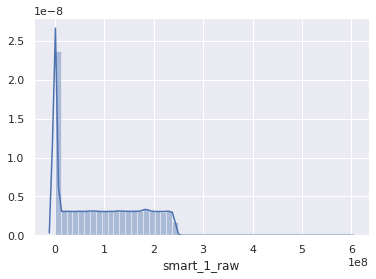

[########################################] | 100% Completed | 34.3s
163 out of 4999997 are NaN values. These are not shown on the graph below


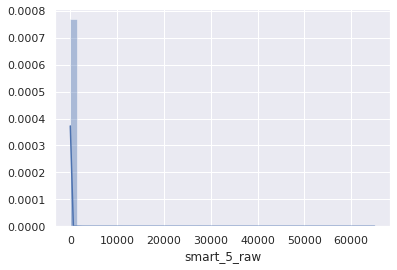

[########################################] | 100% Completed | 33.9s
216 out of 4999997 are NaN values. These are not shown on the graph below


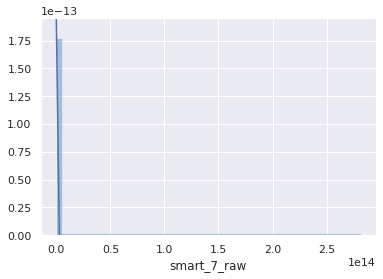

[########################################] | 100% Completed | 33.7s
197 out of 4999997 are NaN values. These are not shown on the graph below


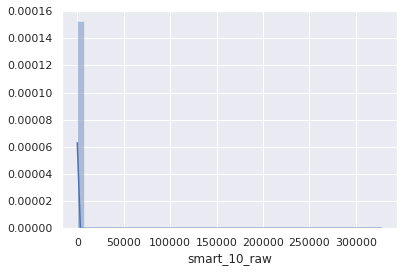

[########################################] | 100% Completed | 33.5s
1216760 out of 4999997 are NaN values. These are not shown on the graph below


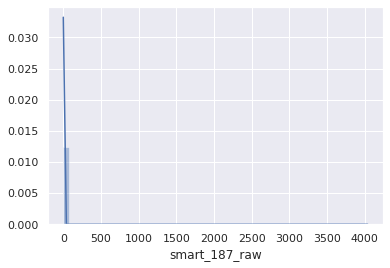

[########################################] | 100% Completed | 33.5s
1217591 out of 4999997 are NaN values. These are not shown on the graph below


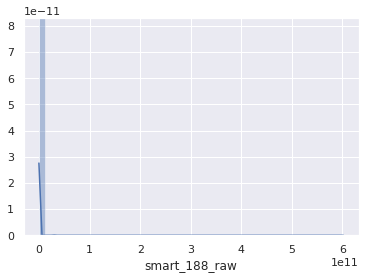

[########################################] | 100% Completed | 33.5s
1214772 out of 4999997 are NaN values. These are not shown on the graph below


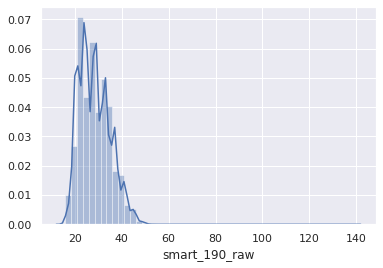

[########################################] | 100% Completed | 33.7s
32765 out of 4999997 are NaN values. These are not shown on the graph below


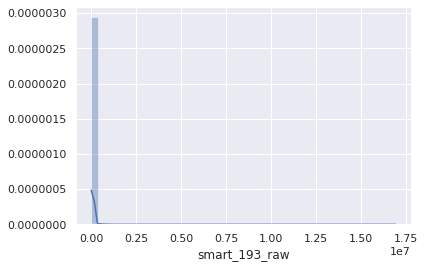

[########################################] | 100% Completed | 33.7s
157 out of 4999997 are NaN values. These are not shown on the graph below


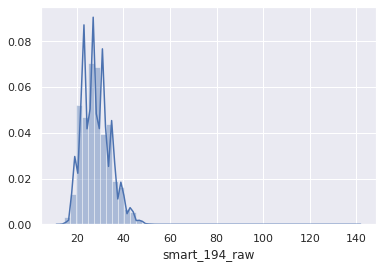

[########################################] | 100% Completed | 37.0s
266 out of 4999997 are NaN values. These are not shown on the graph below


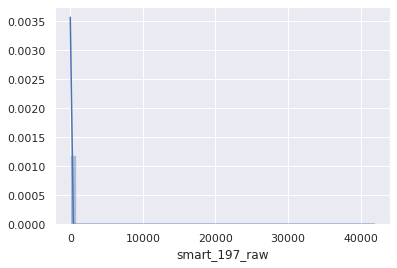

[########################################] | 100% Completed | 33.5s
213 out of 4999997 are NaN values. These are not shown on the graph below


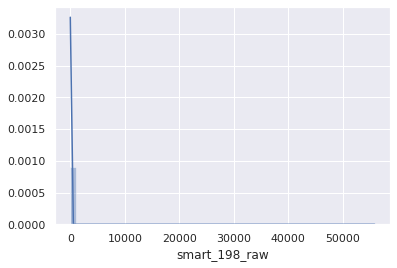

[########################################] | 100% Completed | 33.3s
1148971 out of 4999997 are NaN values. These are not shown on the graph below


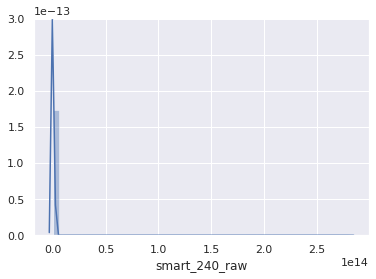

[########################################] | 100% Completed | 33.4s
1217502 out of 4999997 are NaN values. These are not shown on the graph below


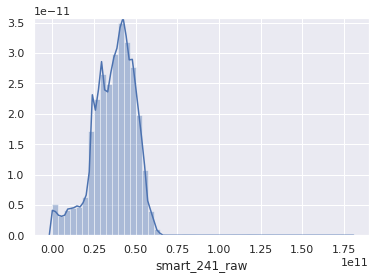

[########################################] | 100% Completed | 33.3s
1216922 out of 4999997 are NaN values. These are not shown on the graph below


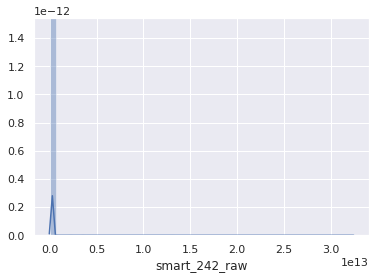

[########################################] | 100% Completed | 33.1s
150 out of 4999997 are NaN values. These are not shown on the graph below


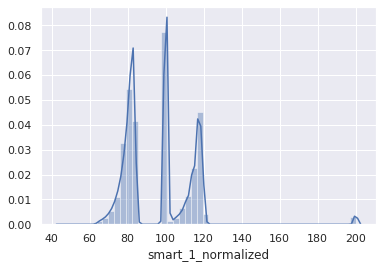

[########################################] | 100% Completed | 33.1s
188 out of 4999997 are NaN values. These are not shown on the graph below


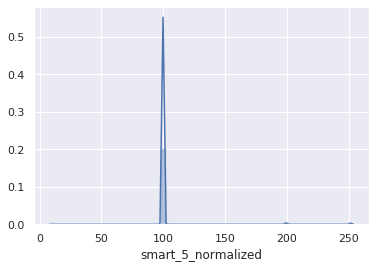

[########################################] | 100% Completed | 33.2s
210 out of 4999997 are NaN values. These are not shown on the graph below


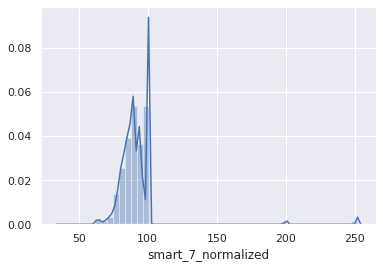

[########################################] | 100% Completed | 33.8s
228 out of 4999997 are NaN values. These are not shown on the graph below


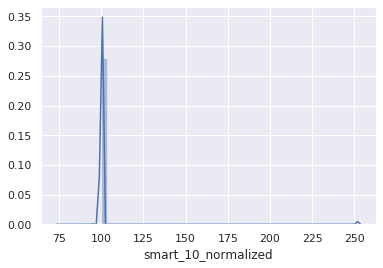

[########################################] | 100% Completed | 33.8s
1218351 out of 4999997 are NaN values. These are not shown on the graph below


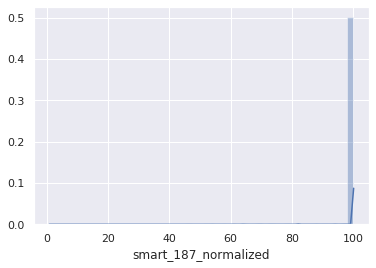

[########################################] | 100% Completed | 33.3s
1216144 out of 4999997 are NaN values. These are not shown on the graph below


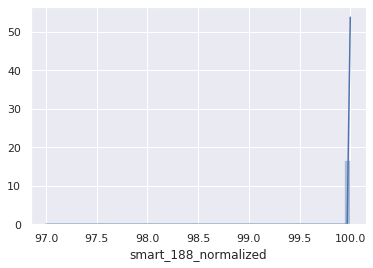

[########################################] | 100% Completed | 33.3s
1217148 out of 4999997 are NaN values. These are not shown on the graph below


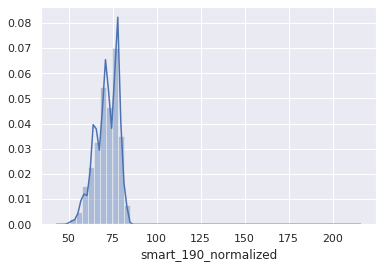

[########################################] | 100% Completed | 33.4s
32848 out of 4999997 are NaN values. These are not shown on the graph below


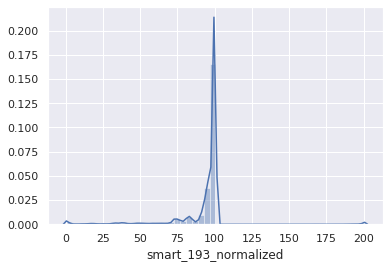

[########################################] | 100% Completed | 33.4s
142 out of 4999997 are NaN values. These are not shown on the graph below


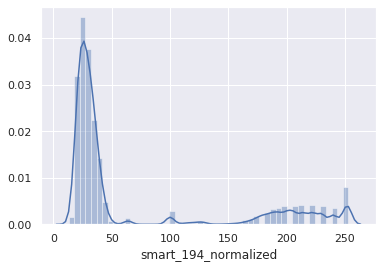

[########################################] | 100% Completed | 33.3s
220 out of 4999997 are NaN values. These are not shown on the graph below


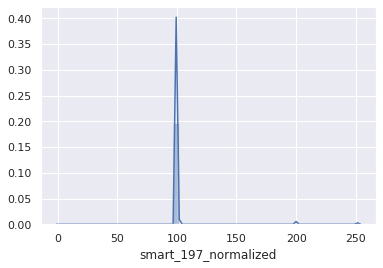

[########################################] | 100% Completed | 33.3s
217 out of 4999997 are NaN values. These are not shown on the graph below


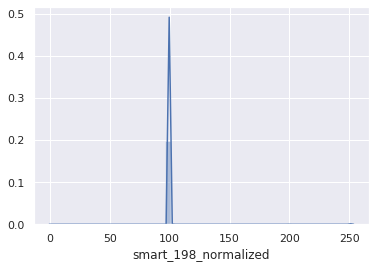

[########################################] | 100% Completed | 33.5s
1148709 out of 4999997 are NaN values. These are not shown on the graph below


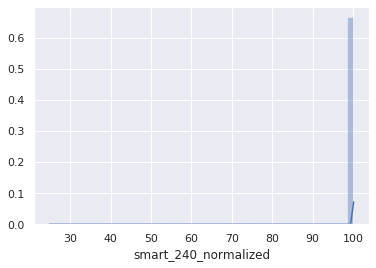

[########################################] | 100% Completed | 34.0s
1216598 out of 4999997 are NaN values. These are not shown on the graph below


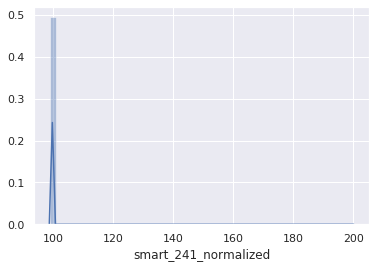

[########################################] | 100% Completed | 33.1s
1217544 out of 4999997 are NaN values. These are not shown on the graph below


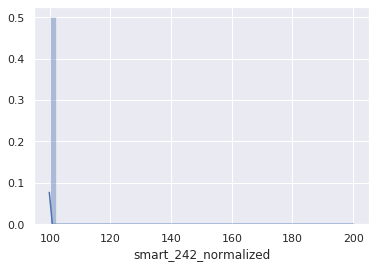

In [43]:
# plot histograms for overall data
# it would probably be more insightful to do this per vendor, but start with overall
# dont make the hist if all values are nan
hist_cols = nan_count.index[nan_count['percent'] < 0.25]    # + ['failure', 'capacity_bytes']
len_df = len(df)
for col in hist_cols:
    # get all the values for this column
    if num_rows_to_sample < len_df:
        data = df[col].sample(frac=num_rows_to_sample/len_df).compute()
    else:
        data = df[col].compute()

    # plot only the non null values
    print(data.isna().sum(), 'out of', data.shape[0], 'are NaN values. These are not shown on the graph below')
    sns.distplot(data[~data.isna()])
    plt.show()

[########################################] | 100% Completed |  5min 40.7s


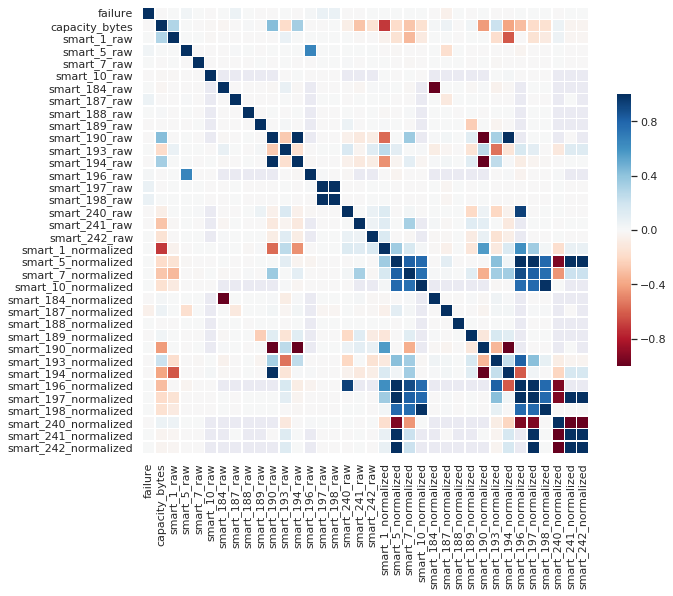

In [65]:
# correlation with failure
# corr_cols = ['failure', 'capacity_bytes'] + crit_cols_raw + crit_cols_normalized
corr_cols = ['failure', 'capacity_bytes'] + list(nan_count.index[nan_count['percent'] != 1])
downsampled_sers = failed_sers['serial_number'].sample(n=500).values.tolist() + working_sers['serial_number'].sample(n=75000).values.tolist()
corr_mat = df[df['serial_number'].isin(downsampled_sers)][corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_mat,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

In [66]:
# only those attributes with less than NAN_PERCENT_THRESHOLD% values as NaN's
# will be selected for computing the correaltion matirx
NAN_PERCENT_THRESHOLD = 0.5

[########################################] | 100% Completed |  4min  7.8s


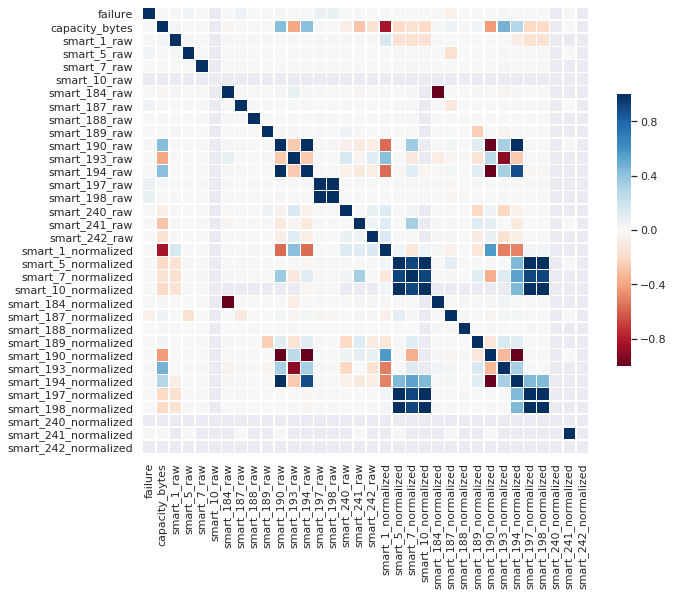

In [68]:
# correlation matrix for seagaet drives
seagate_corr_cols = ['failure', 'capacity_bytes']  + list(seagate_nan_ct.index[seagate_nan_ct['percent'] < NAN_PERCENT_THRESHOLD])
seagate_corr = seagate_df[seagate_df['serial_number'].isin(downsampled_sers)][seagate_corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(seagate_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

[########################################] | 100% Completed | 57.5s


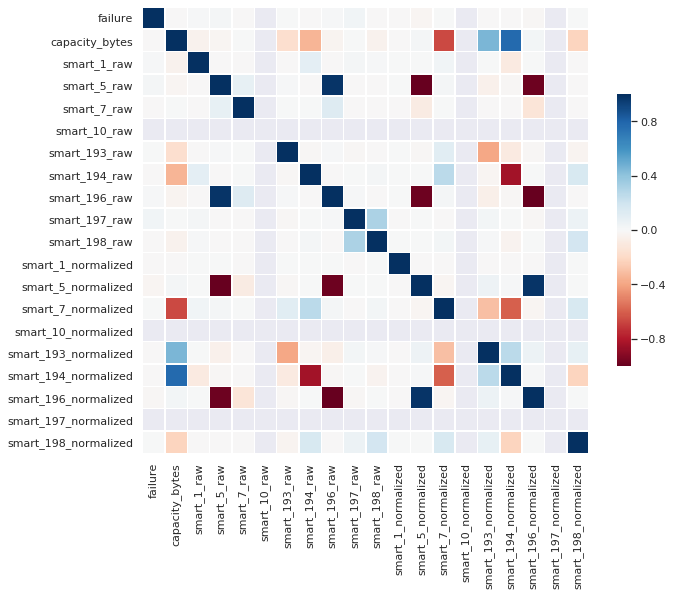

In [69]:
# correlation matrix for wdc drives
wdc_corr_cols = ['failure', 'capacity_bytes'] + list(wdc_nan_ct.index[wdc_nan_ct['percent'] < NAN_PERCENT_THRESHOLD])
wdc_corr = wdc_df[wdc_corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(wdc_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

[########################################] | 100% Completed |  1min 22.2s


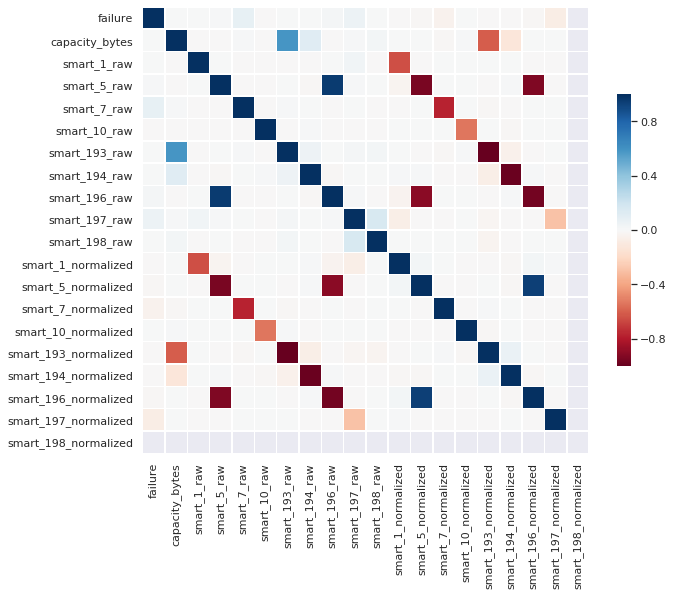

In [70]:
# correlation matrix for hgst drives
hgst_corr_cols = ['failure', 'capacity_bytes'] + list(hgst_nan_ct.index[hgst_nan_ct['percent'] < NAN_PERCENT_THRESHOLD])
hgst_corr = hgst_df[hgst_corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(hgst_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

[########################################] | 100% Completed | 56.9s


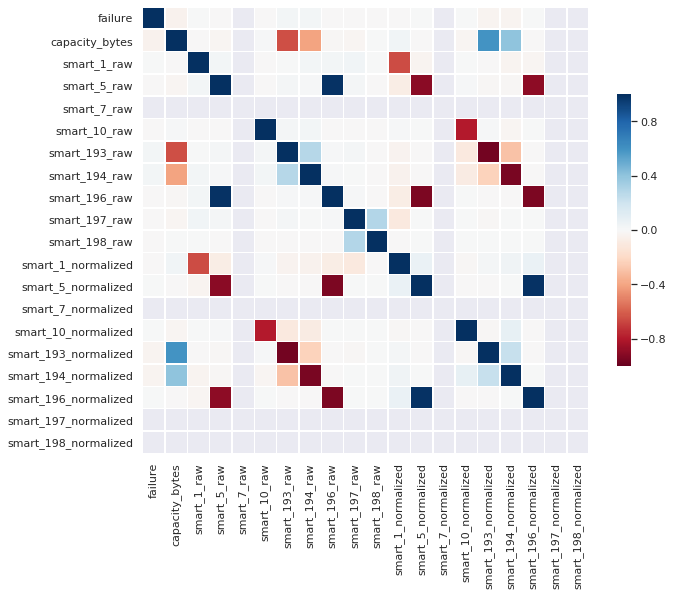

In [71]:
# correlation matrix for hitachi drives
hitachi_corr_cols = ['failure', 'capacity_bytes'] + list(hitachi_nan_ct.index[hitachi_nan_ct['percent'] < NAN_PERCENT_THRESHOLD])
hitachi_corr = hitachi_df[hitachi_corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(hitachi_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

[########################################] | 100% Completed |  1min  0.3s


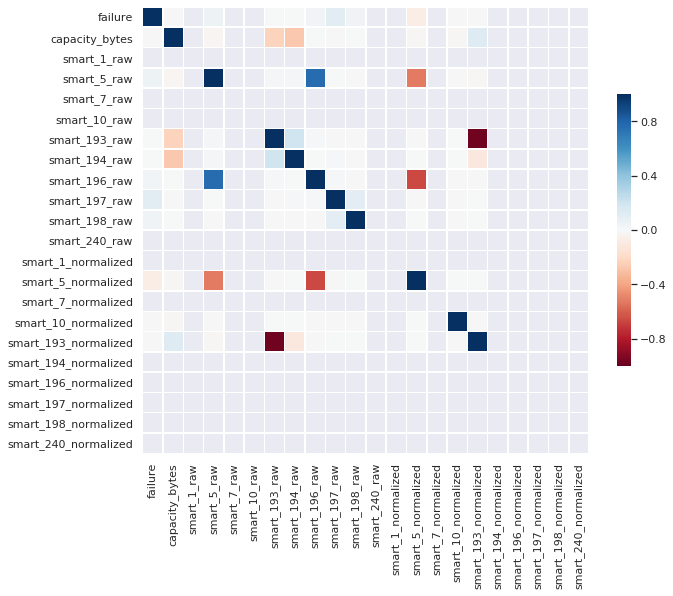

In [72]:
# correlation matrix for toshiba drives
toshiba_corr_cols = ['failure', 'capacity_bytes'] + list(toshiba_nan_ct.index[toshiba_nan_ct['percent'] < NAN_PERCENT_THRESHOLD])
toshiba_corr = toshiba_df[toshiba_corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(toshiba_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

1 / 50. Drive serial number 175PP3I7T
[########################################] | 100% Completed |  1min 11.8s
2 / 50. Drive serial number S2ZYJ9CFC01460
[########################################] | 100% Completed |  1min 12.7s
3 / 50. Drive serial number Z4D0D1V1
[########################################] | 100% Completed |  1min 12.4s
4 / 50. Drive serial number Z304JMAM
[########################################] | 100% Completed |  1min 11.4s
5 / 50. Drive serial number ZJV03CQH
[########################################] | 100% Completed |  1min 11.9s
6 / 50. Drive serial number 88Q0A01NF97G
[########################################] | 100% Completed |  1min 11.9s
7 / 50. Drive serial number ZA181AA1
[########################################] | 100% Completed |  1min 11.7s
8 / 50. Drive serial number Z3025KZQ
[########################################] | 100% Completed |  1min 11.9s
9 / 50. Drive serial number S301PQF4
[########################################] | 100% Completed |  1

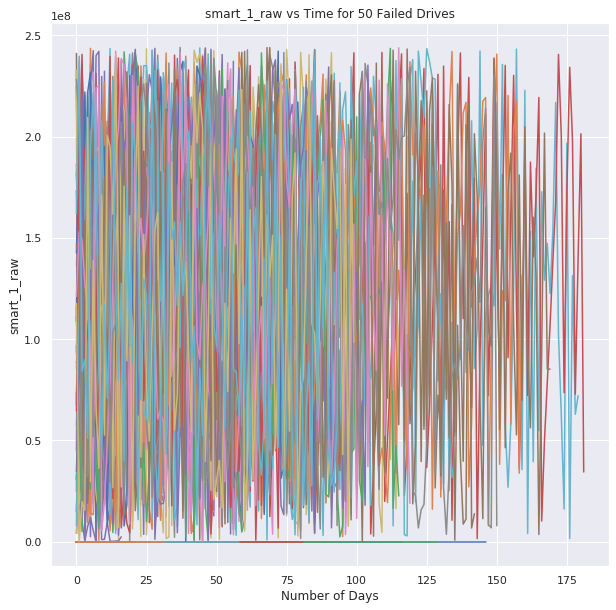

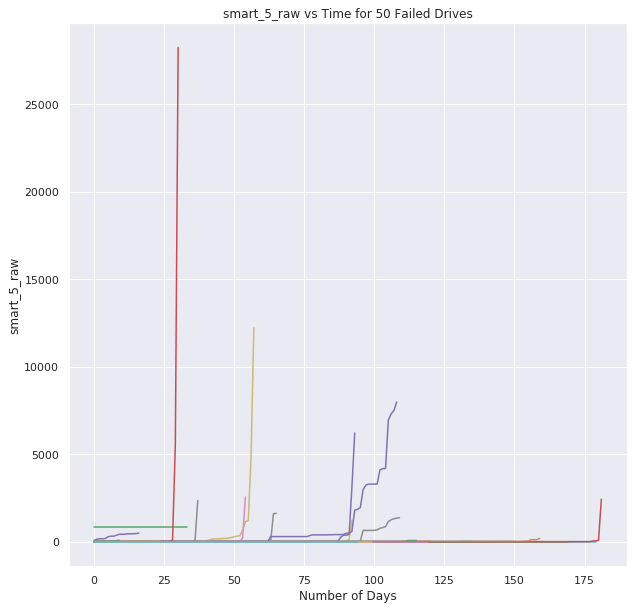

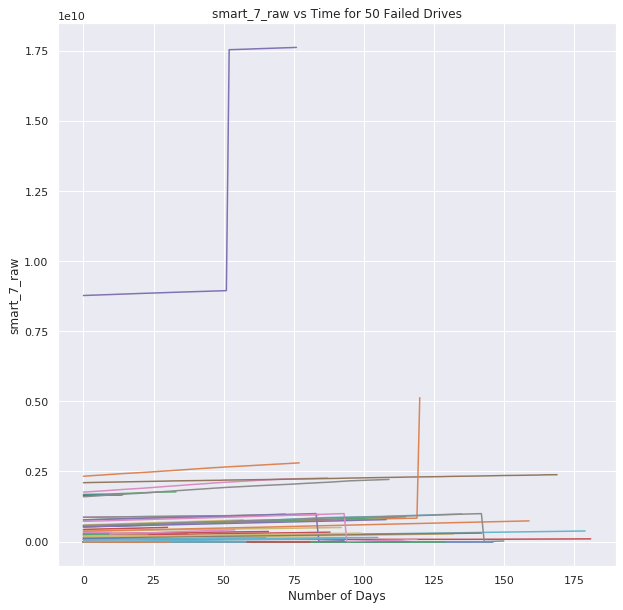

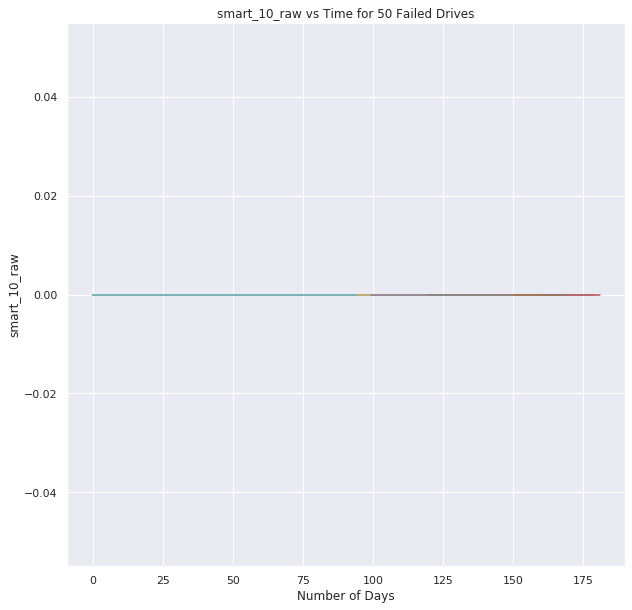

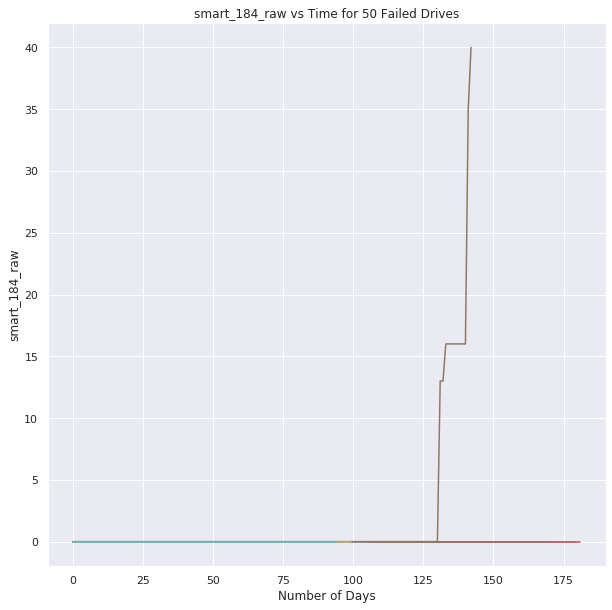

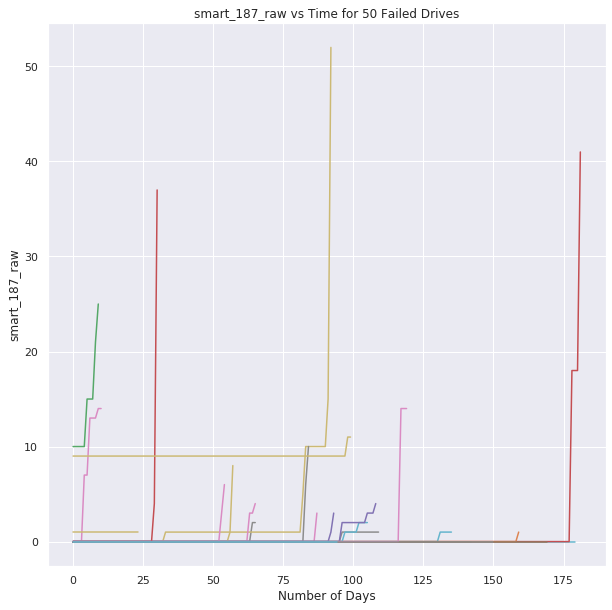

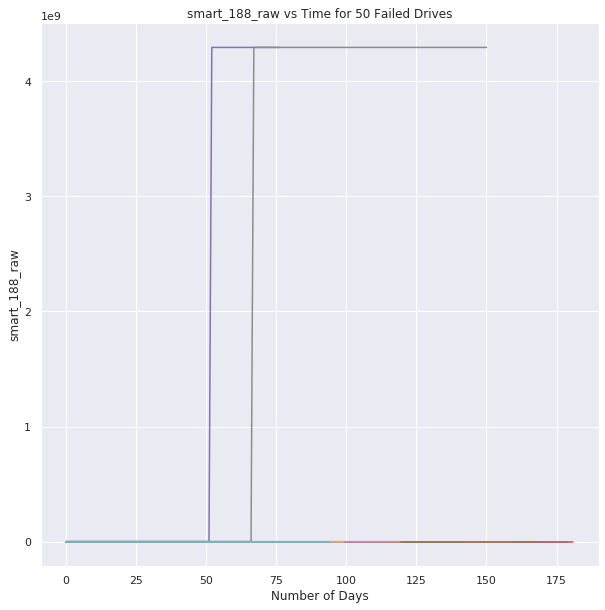

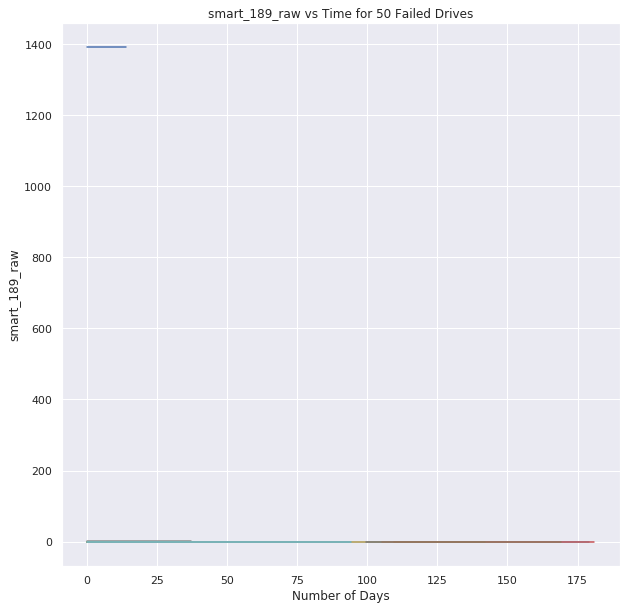

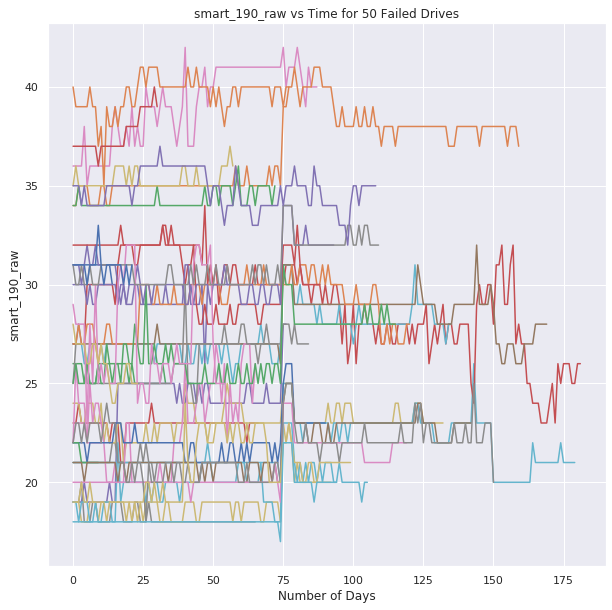

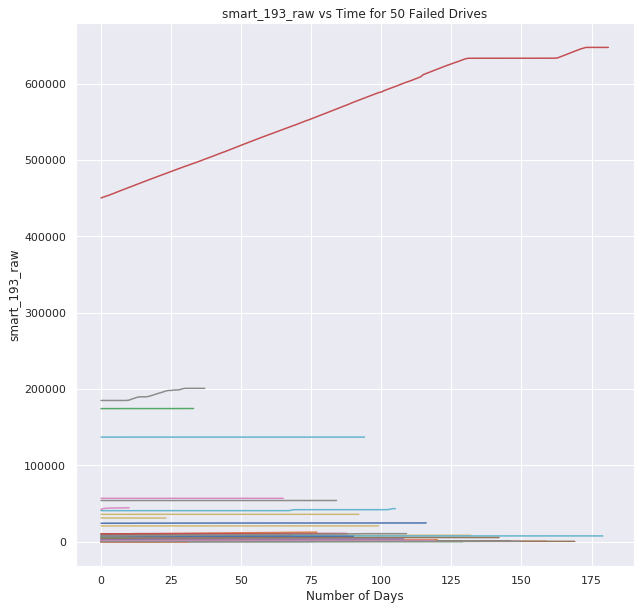

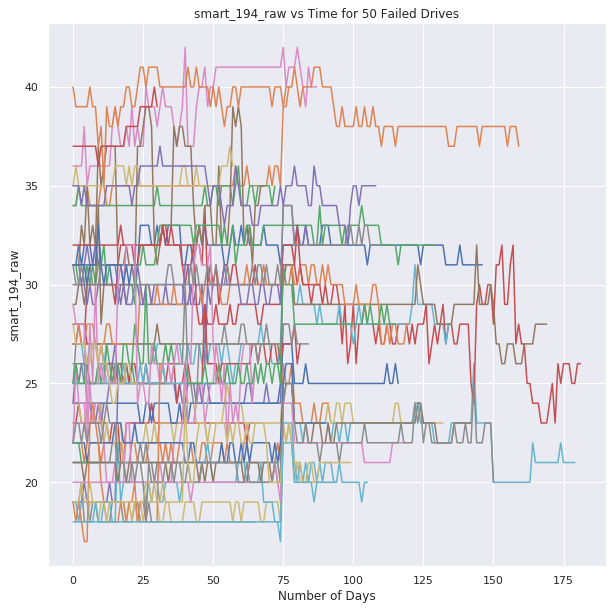

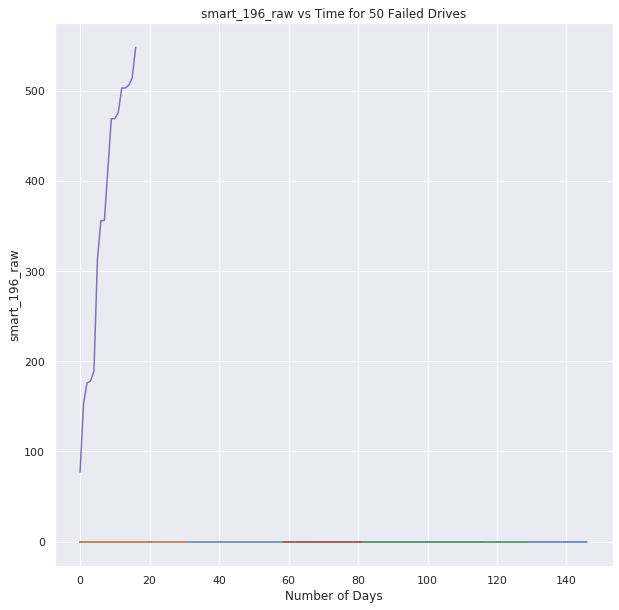

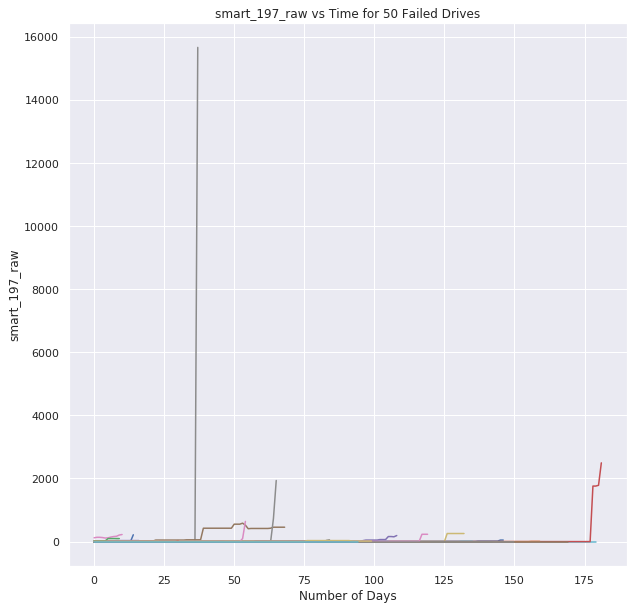

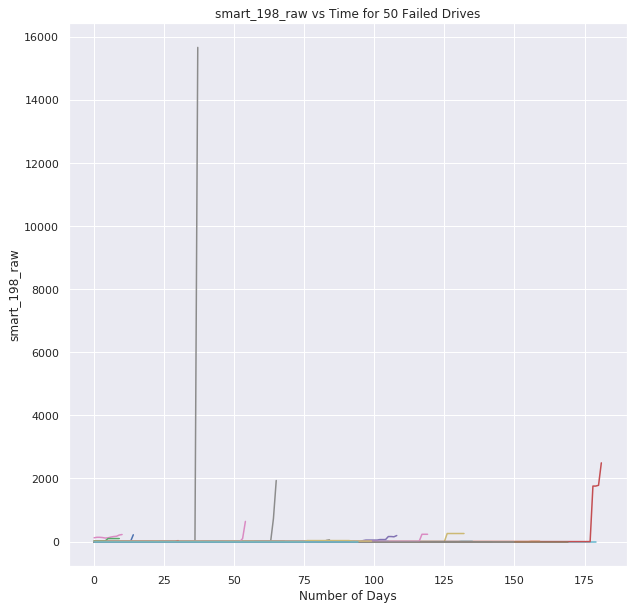

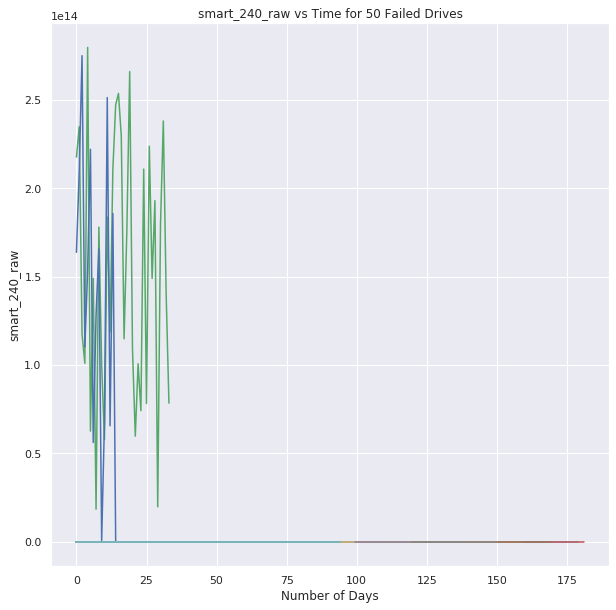

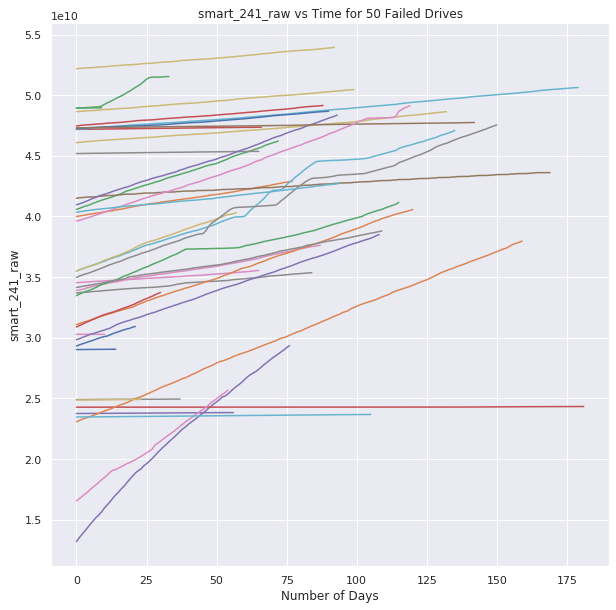

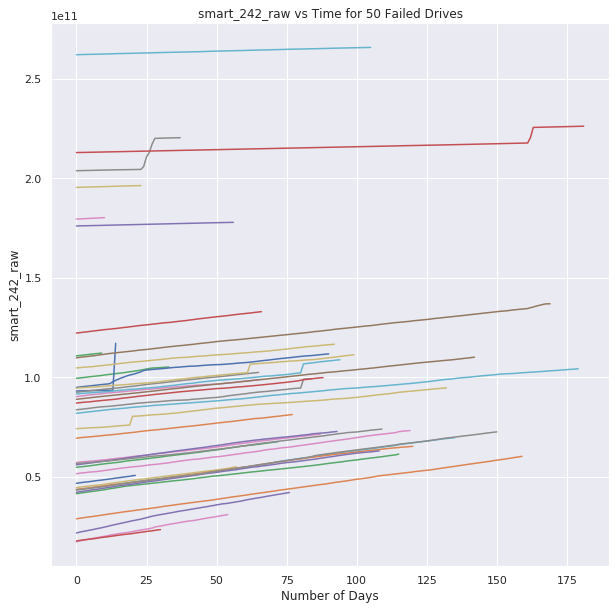

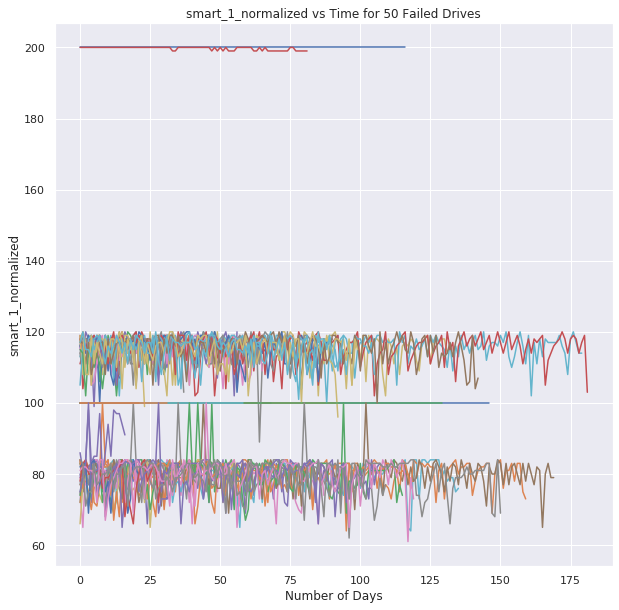

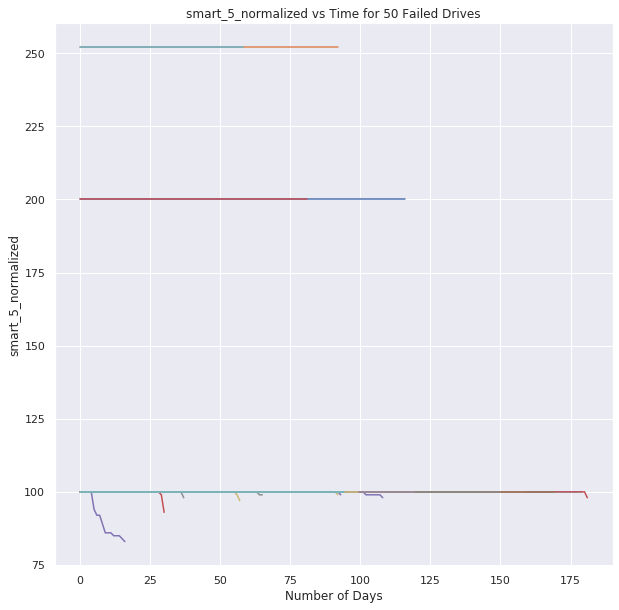

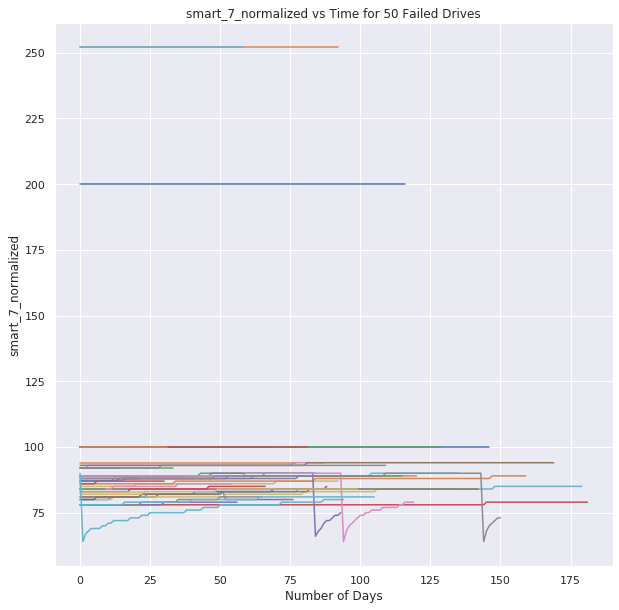

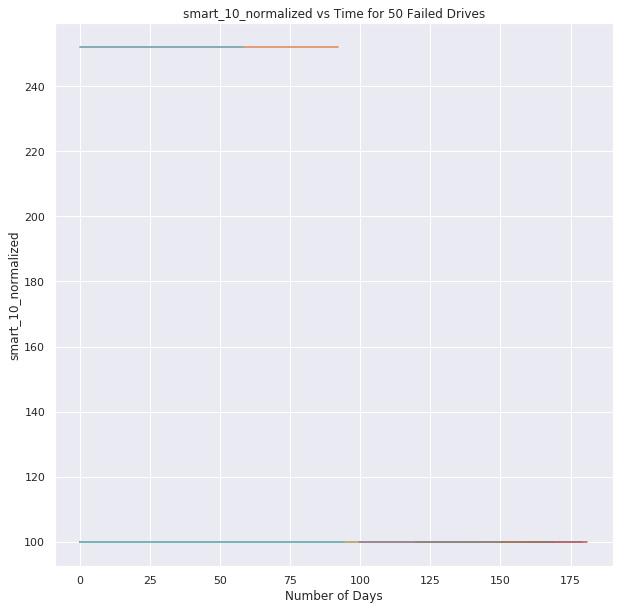

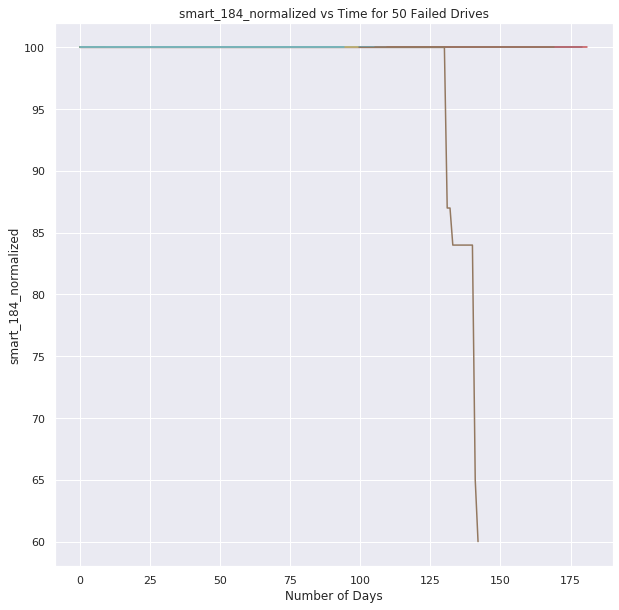

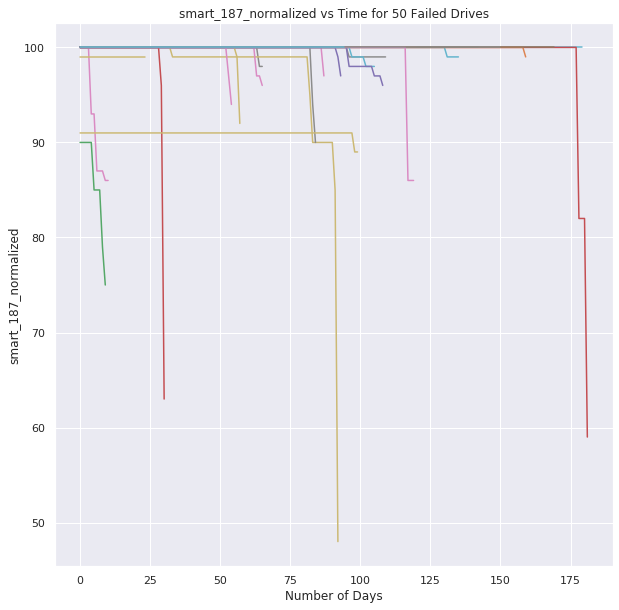

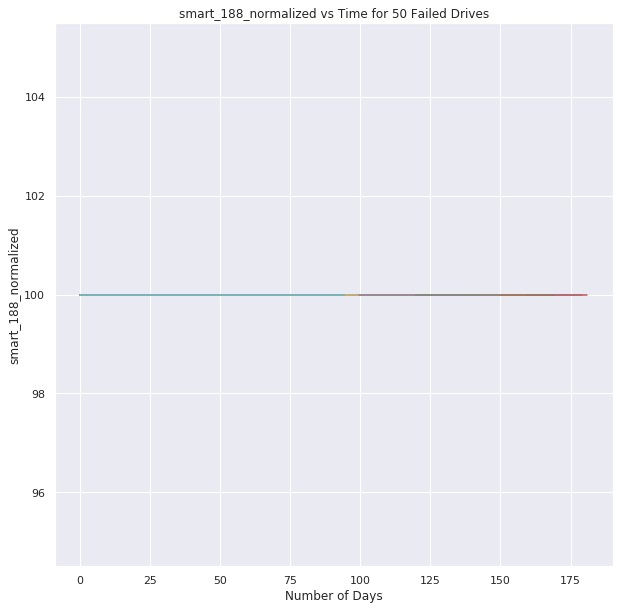

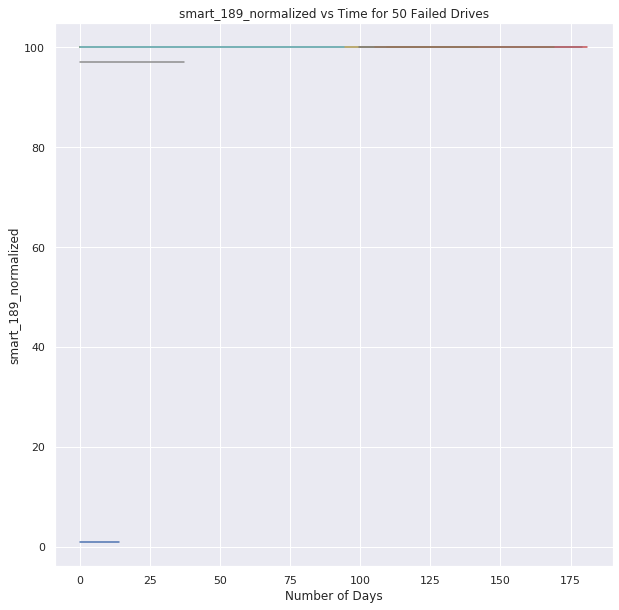

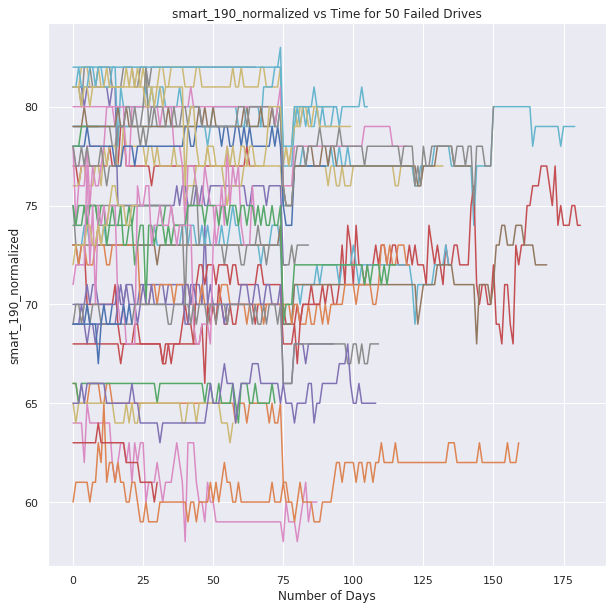

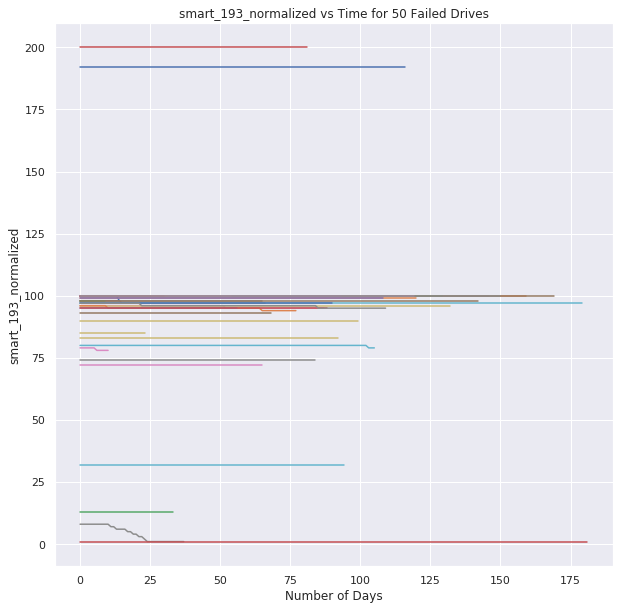

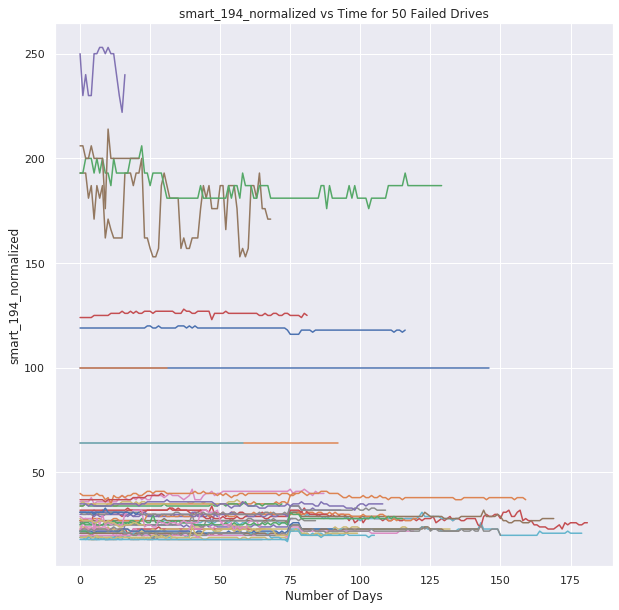

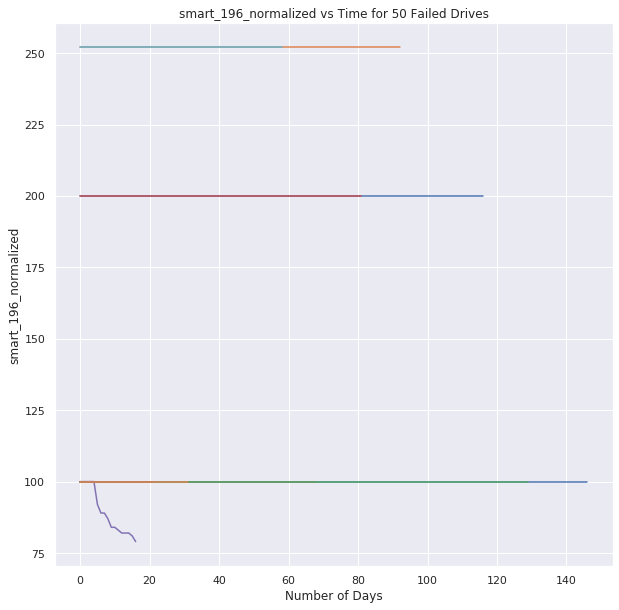

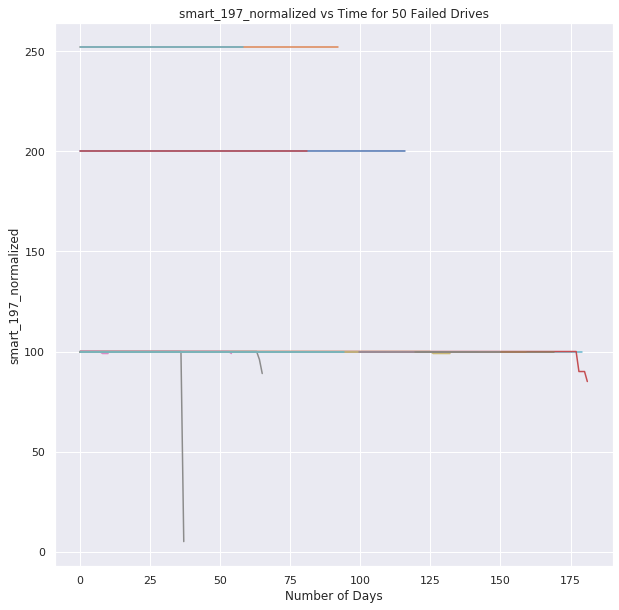

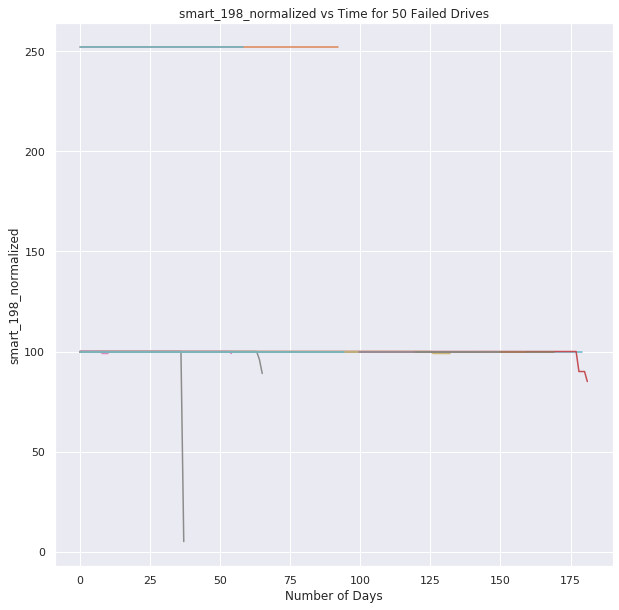

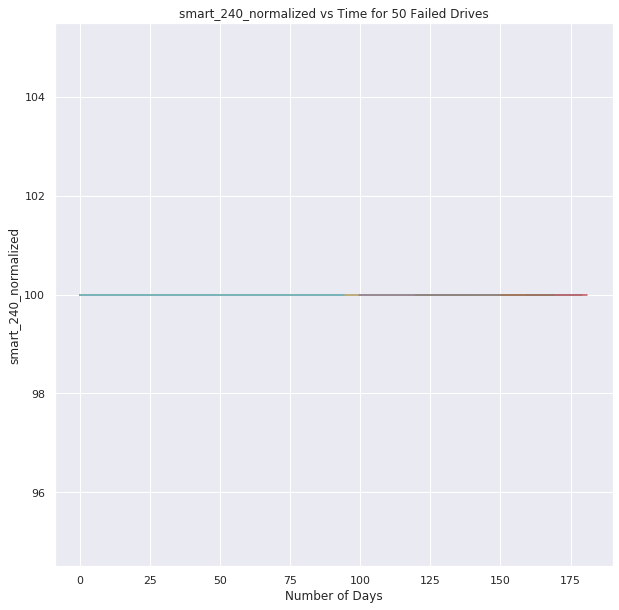

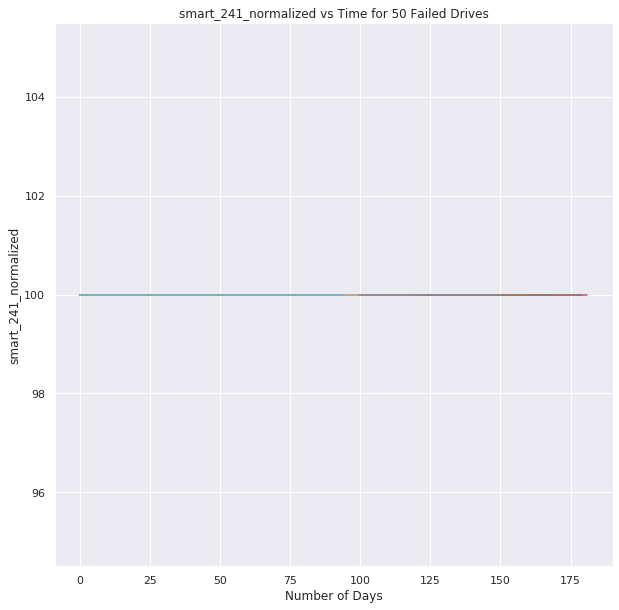

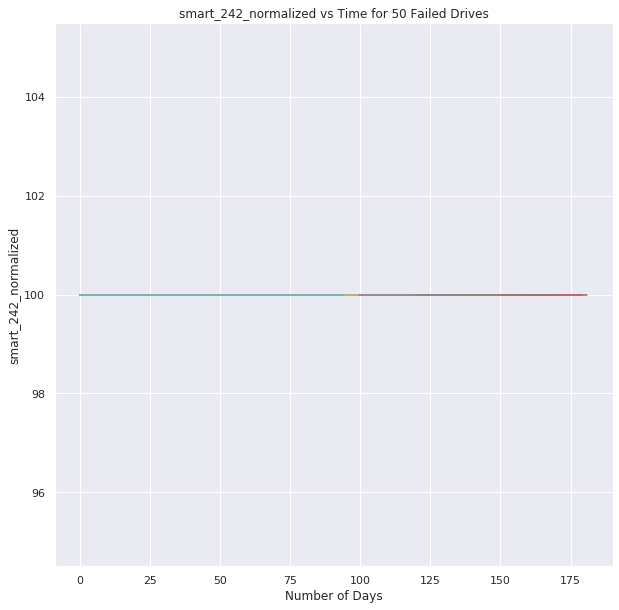

In [62]:
# TODO: Might be better to call compute to get the combined data of all serials in subset
# as opposed to calling it for earch serial number in for loop

# NOTE: running this cell will take a VERY long time (~1hr on intel i7 w/ 16GB ram)
# adjust NUM_DRIVES_TO_SAMPLE to select a small subset to use for plotting
NUM_DRIVES_TO_SAMPLE = 50

# plots for smart stat 5
# cols_to_plot = ['smart_5_raw', 'smart_7_raw']
cols_to_plot = crit_cols_raw + crit_cols_normalized
cols_to_plot.remove('smart_201_raw')            # too many nans
cols_to_plot.remove('smart_201_normalized')     # too many nans

# one figure per smart stat
figs = [plt.figure(i, figsize=(10, 10)) for i in range(len(cols_to_plot))]
axes = [f.add_subplot(111) for f in figs]
for colname, ax in zip(cols_to_plot, axes):
    ax.set_title('{} vs Time for {} Failed Drives'.format(colname, NUM_DRIVES_TO_SAMPLE))
    ax.set_xlabel('Number of Days')
    ax.set_ylabel(colname)
    
# keep track of what hard drives were used to generate the data. NOTE: only the first 16 chars of ser will be saved
failed_ser_subset = np.empty(shape=(NUM_DRIVES_TO_SAMPLE), dtype='<S16')

# make the figures
for i, ser in enumerate(failed_serials['serial_number'].sample(NUM_DRIVES_TO_SAMPLE, random_state=42)):
    # log serial numbers which are being used
    failed_ser_subset[i] = ser
    print('{} / {}. Drive serial number {}'.format(i + 1, NUM_DRIVES_TO_SAMPLE, ser))
    
    # get teh data to make the figures
    drive_data = df[df['serial_number']==ser][cols_to_plot].compute()
    
    # dummy x axis data
    xvals = [i for i in range(drive_data.shape[0])]
    
    # make the plot
    for ax, c in zip(axes, cols_to_plot):
        ax.plot(xvals, drive_data[c])

# save the figures
for f, c in zip(figs, cols_to_plot):
    f.savefig('img/{}_failed.png'.format(c))

# save the serial numbres used in figures
np.save('failed_graphs_serials', failed_ser_subset)

In [ ]:
# sample to use for plotting
NUM_DRIVES_TO_SAMPLE = 50

# one figure per smart stat
for colname, ax in zip(cols_to_plot, axes):
    ax.cla()    # clear data from previous plots
    ax.set_title('{} vs Time for {} Working Drives'.format(colname, NUM_DRIVES_TO_SAMPLE))
    ax.set_xlabel('Number of Days')
    ax.set_ylabel(colname)
    
# keep track of what hard drives were used to generate the data. NOTE: only the first 16 chars of ser will be saved
working_ser_subset = np.empty(shape=(NUM_DRIVES_TO_SAMPLE), dtype='<S16')

# make the figures
for i, ser in enumerate(working_serials['serial_number'].sample(NUM_DRIVES_TO_SAMPLE, random_state=42)):
    # log serial numbers which are being used
    working_ser_subset[i] = ser
    print('{} / {}. Drive serial number {}'.format(i + 1, NUM_DRIVES_TO_SAMPLE, ser))
    
    # get teh data to make the figures
    drive_data = df[df['serial_number']==ser][cols_to_plot].compute()
    
    # dummy x axis data
    xvals = [i for i in range(drive_data.shape[0])]
    
    # make the plot
    for ax, c in zip(axes, cols_to_plot):
        ax.plot(xvals, drive_data[c])

# save the figures
for f, c in zip(figs, cols_to_plot):
    f.savefig('img/{}_working.png'.format(c))

# save the serial numbres used in figures
np.save('working_graphs_serials', working_ser_subset)

In [ ]:
plt.close('all')

### Backblaze's analysis:

Backblaze also performed some analysis on the SMART stats 5, 187, 188, 197, 198. They concluded that just having one of the stats in an abnormal state may not necessarily mean anything, but all of them being abnormal at the same time is a red flag. Details and some nice diagrams can be found here: https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/

## Visualize Embeddings

In [73]:
from dask.distributed import Client
# from sklearn.externals.joblib import parallel_backend

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import StandardScaler

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import seaborn as sns

In [74]:
# get the groupby object. there should be one gourp per serial nunmbers
# get only those columns which have less than 50 percent nan values
grouped_data_cols = ['serial_number', 'model', 'capacity_bytes'] + list(nan_count.index[nan_count['percent'] < 0.5])
groups = df[grouped_data_cols].groupby('serial_number')

In [75]:
# get simple stats to represent time series of each hard drive
group_means = groups.mean().compute().add_prefix('mean_')
group_stds = groups.std().compute().add_prefix('std_')
# group_days = groups.size().compute().to_frame('days')
# group_days.index.name = None    # to match the other agg results, so that it can be concatenated easily

[########################################] | 100% Completed |  2min  7.3s
[########################################] | 100% Completed |  2min 30.3s


In [77]:
# put the stats together into one df
group_stats = pd.concat([group_means, group_stds], axis=1)

# make serial number a column instead of index. will be easier for calc later
group_stats = group_stats.reset_index()

# need to add failed label
group_stats['failure'] = group_stats['serial_number'].isin(failed_sers['serial_number'])

group_stats.head()

,serial_number,mean_capacity_bytes,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_184_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_189_raw,mean_smart_190_raw,mean_smart_193_raw,mean_smart_194_raw,mean_smart_197_raw,mean_smart_198_raw,mean_smart_240_raw,mean_smart_241_raw,mean_smart_242_raw,mean_smart_1_normalized,mean_smart_5_normalized,mean_smart_7_normalized,mean_smart_10_normalized,mean_smart_184_normalized,mean_smart_187_normalized,mean_smart_188_normalized,mean_smart_189_normalized,mean_smart_190_normalized,mean_smart_193_normalized,mean_smart_194_normalized,mean_smart_197_normalized,mean_smart_198_normalized,mean_smart_240_normalized,mean_smart_241_normalized,mean_smart_242_normalized,std_capacity_bytes,std_smart_1_raw,std_smart_5_raw,std_smart_7_raw,std_smart_10_raw,std_smart_184_raw,std_smart_187_raw,std_smart_188_raw,std_smart_189_raw,std_smart_190_raw,std_smart_193_raw,std_smart_194_raw,std_smart_197_raw,std_smart_198_raw,std_smart_240_raw,std_smart_241_raw,std_smart_242_raw,std_smart_1_normalized,std_smart_5_normalized,std_smart_7_normalized,std_smart_10_normalized,std_smart_184_normalized,std_smart_187_normalized,std_smart_188_normalized,std_smart_189_normalized,std_smart_190_normalized,std_smart_193_normalized,std_smart_194_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_240_normalized,std_smart_241_normalized,std_smart_242_normalized,failure
0,175PP3HDT,5.001079e+11,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,933.293151,33.008219,0.000000,0.0,0.0,NaN,NaN,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,44.974722,1.216841,0.000000,0.0,0.0,NaN,NaN,0.010974,0.010974,0.010974,0.010974,NaN,NaN,NaN,NaN,NaN,0.010974,0.010974,0.010974,0.010974,0.010974,NaN,NaN,False
1,175PP3I4T,5.001079e+11,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2175.139726,39.224658,0.000000,0.0,0.0,NaN,NaN,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,6.571260,1.718963,0.000000,0.0,0.0,NaN,NaN,0.010974,0.010974,0.010974,0.010974,NaN,NaN,NaN,NaN,NaN,0.010974,0.010974,0.010974,0.010974,0.010974,NaN,NaN,False
2,175PP3I5T,5.001079e+11,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2024.745205,36.863014,0.000000,0.0,0.0,NaN,NaN,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.491750,2.025357,0.000000,0.0,0.0,NaN,NaN,0.010974,0.010974,0.010974,0.010974,NaN,NaN,NaN,NaN,NaN,0.010974,0.010974,0.010974,0.010974,0.010974,NaN,NaN,False
3,175PP3I6T,5.001079e+11,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1861.000000,34.747945,0.000000,0.0,0.0,NaN,NaN,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,1.314325,0.000000,0.0,0.0,NaN,NaN,0.010974,0.010974,0.010974,0.010974,NaN,NaN,NaN,NaN,NaN,0.010974,0.010974,0.010974,0.010974,0.010974,NaN,NaN,False
4,175PP3I7T,5.001079e+11,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1020.292683,31.283537,2.609756,0.0,0.0,NaN,NaN,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,46.040017,0.999440,5.383759,0.0,0.0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,True


In [78]:
# FIXME: find a smarter way to deal with nans. drop columns not rows
# for now, just drop it. this drops ~25k observations and leaves us with ~83k
clean_group_stats = group_stats.dropna(how='any')

# make sure we still have enough failure drive data
print(clean_group_stats['failure'].sum(), 'failed drives data retained')

clean_group_stats[clean_group_stats['failure']].head()

835 failed drives data retained


,serial_number,mean_capacity_bytes,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_184_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_189_raw,mean_smart_190_raw,mean_smart_193_raw,mean_smart_194_raw,mean_smart_197_raw,mean_smart_198_raw,mean_smart_240_raw,mean_smart_241_raw,mean_smart_242_raw,mean_smart_1_normalized,mean_smart_5_normalized,mean_smart_7_normalized,mean_smart_10_normalized,mean_smart_184_normalized,mean_smart_187_normalized,mean_smart_188_normalized,mean_smart_189_normalized,mean_smart_190_normalized,mean_smart_193_normalized,mean_smart_194_normalized,mean_smart_197_normalized,mean_smart_198_normalized,mean_smart_240_normalized,mean_smart_241_normalized,mean_smart_242_normalized,std_capacity_bytes,std_smart_1_raw,std_smart_5_raw,std_smart_7_raw,std_smart_10_raw,std_smart_184_raw,std_smart_187_raw,std_smart_188_raw,std_smart_189_raw,std_smart_190_raw,std_smart_193_raw,std_smart_194_raw,std_smart_197_raw,std_smart_198_raw,std_smart_240_raw,std_smart_241_raw,std_smart_242_raw,std_smart_1_normalized,std_smart_5_normalized,std_smart_7_normalized,std_smart_10_normalized,std_smart_184_normalized,std_smart_187_normalized,std_smart_188_normalized,std_smart_189_normalized,std_smart_190_normalized,std_smart_193_normalized,std_smart_194_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_240_normalized,std_smart_241_normalized,std_smart_242_normalized,failure
25245,S300V3AD,4.000787e+12,1.477581e+08,8.00000,1.706016e+07,0.0,0.0,2.000000,0.0,0.0,24.000000,1373.500000,24.000000,8.000000,8.000000,733.500000,7.855681e+09,9.421427e+08,115.000000,100.000000,72.000000,100.0,100.0,98.000000,100.0,100.0,76.000000,100.0,24.000000,100.000000,100.000000,100.0,100.0,100.0,0.000000e+00,1.013742e+08,11.313708,3.925327e+05,0.0,0.0,2.828427,0.0,0.0,0.000000,0.707107,0.000000,11.313708,11.313708,16.263456,2.965821e+06,2.004330e+07,5.656854,0.000000,0.000000,0.000000,0.000000,2.828427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
25332,S300VL6S,4.000787e+12,1.224876e+08,15.47541,2.820471e+08,0.0,0.0,2.885246,0.0,0.0,29.836066,46223.196721,29.836066,4.983607,4.983607,21735.639344,4.831991e+10,6.951972e+10,115.081967,99.983607,77.622951,100.0,100.0,98.278689,100.0,100.0,70.163934,77.0,29.836066,99.983607,99.983607,100.0,100.0,100.0,1.555392e+09,7.510494e+07,119.829825,4.248969e+08,0.0,0.0,21.767023,0.0,0.0,2.130574,8.194360,2.130574,38.923211,38.923211,427.247692,2.731702e+08,2.939588e+09,4.148474,0.129099,8.157148,0.000000,0.000000,12.686133,0.000000,0.000000,2.130574,0.016529,2.130574,0.129099,0.129099,0.000000,0.000000,0.000000,True
25345,S300VL9M,4.000787e+12,1.189316e+08,0.00000,2.603642e+08,0.0,0.0,0.000000,0.0,0.0,23.928177,37725.588398,23.928177,0.000000,0.000000,25721.668508,5.057224e+10,8.722665e+10,114.928177,100.000000,82.651934,100.0,100.0,100.000000,100.0,100.0,76.071823,82.0,23.928177,100.000000,100.000000,100.0,100.0,100.0,6.516147e+08,7.218180e+07,0.000000,1.447159e+08,0.0,0.0,0.000000,0.0,0.0,1.106695,35.166457,1.106695,0.000000,0.000000,2517.029672,1.750767e+09,1.401718e+10,4.270681,0.022130,3.562712,0.022130,0.022130,0.022130,0.022130,0.022130,1.106695,0.011065,1.106695,0.022130,0.022130,0.022130,0.022130,0.022130,True
25442,S300WCLM,4.000787e+12,1.304328e+08,0.00000,2.310999e+08,0.0,0.0,3.052402,0.0,0.0,20.139738,34587.135371,20.139738,0.000000,0.000000,24127.454148,4.989504e+10,7.959794e+10,115.886463,100.000000,81.864629,100.0,100.0,96.947598,100.0,100.0,79.860262,83.0,20.139738,100.000000,100.000000,100.0,100.0,100.0,1.897599e+09,6.761556e+07,0.000000,2.152696e+08,0.0,0.0,0.223324,0.0,0.0,1.095302,44.154552,1.095302,0.000000,0.000000,1589.720013,9.884072e+08,9.903793e+09,3.253154,0.017506,3.609668,0.017506,0.017506,0.222680,0.017506,0.017506,1.095302,0.004376,1.095302,0.017506,0.017506,0.017506,0.017506,0.017506,True
25547,S300WDLE,4.000787e+12,1.234360e+08,0.00000,5.976873e+08,0.0,0.0,0.000000,0.0,0.0,18.626812,1368

**NOTE** The percentage of failed hard drives retained is 312/393 = 0.79, and the percentage of healthy hard drives retained is 0.77. So in terms of NaN values dropped in the call in previous cell, the distribution is evenly spread across failed and healthy. (proportion of NaN is same)

In [79]:
# scale the data and find the top principal components
scaler = StandardScaler()
pca = PCA(n_components=3, random_state=42, whiten=True)\
        .fit_transform(scaler.fit_transform(clean_group_stats.drop(['serial_number', 'failure'], axis=1)))

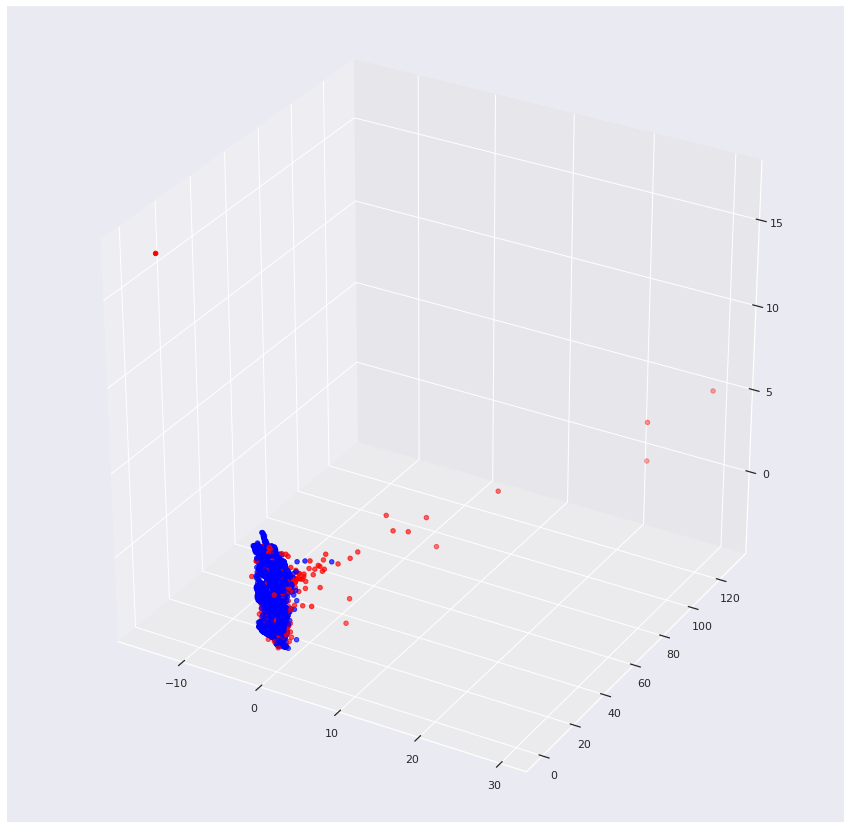

In [80]:
# plot pca
colors = ['blue', 'red']
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca[:, 0],
           pca[:, 1],
           pca[:, 2],
           c=clean_group_stats['failure'],
           cmap=matplotlib.colors.ListedColormap(colors))

In [82]:
# plot umap
from joblib import parallel_backend
from dask.distributed import Client

client = Client()
with parallel_backend('dask'):
    umap = UMAP(n_components=3, random_state=42)\
                .fit_transform(scaler.fit_transform(clean_group_stats.drop(['serial_number', 'failure'], axis=1)))

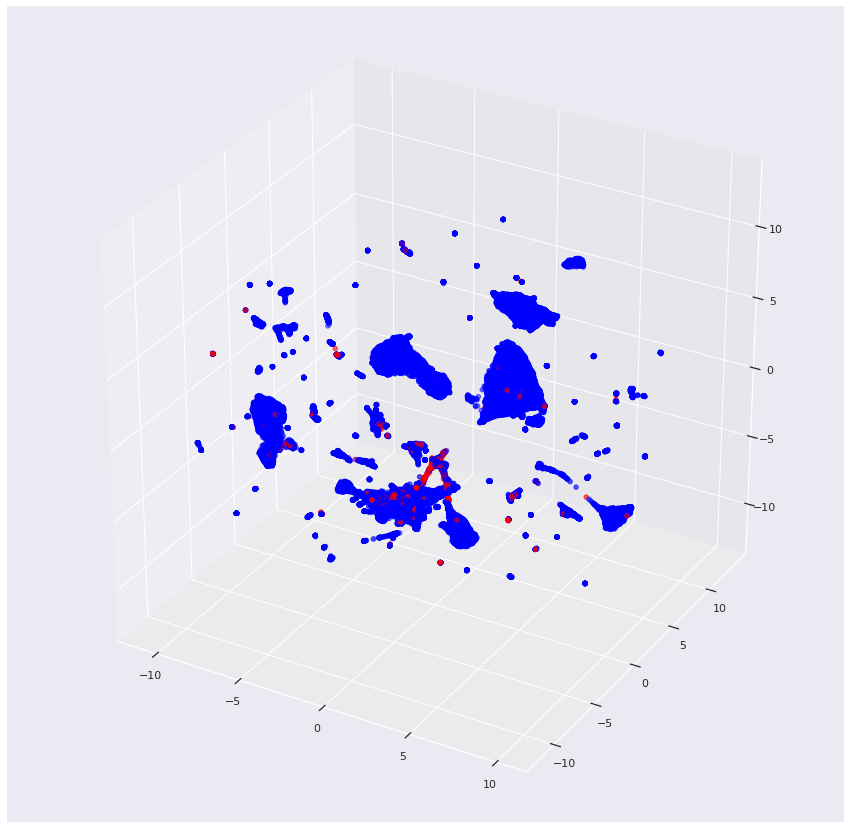

In [83]:
# plot umap
colors = ['blue', 'red']
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap[:, 0],
           umap[:, 1],
           umap[:, 2],
           c=clean_group_stats['failure'],
           cmap=matplotlib.colors.ListedColormap(colors))

In [84]:
# tsne embeddings may be more meaningful than pca, but it is extremely slow
# tsne = TSNE(n_components=3, random_state=42)\
#         .fit_transform(scaler.fit_transform(clean_group_stats.drop(['serial_number', 'failure'], axis=1)))

## SMART 9 Behavior
SMART 9 represents number of power on hours. This can be indicative of lifespan and therefore be useable for the regression problem

In [85]:
# columns to extract from dataset for analyzing
analysis_cols = ['date', 'serial_number', 'smart_9_raw', 'smart_9_normalized']

# columns for which to make histogram
hist_cols = ['smart_9_raw', 'smart_9_normalized']

**NOTE**: The values above have entries from the same drive multiple times -- so it may not be a very good representation of how smart 9 generally is for failed drives. So, we try to get the max entry per serial number (assuming that that would be the latest entry) and plot histogram for that instead

In [86]:
# since failure=1 is marked on the last day that a drive worked, the entries on that day woudl be the most recent ones
# NOTE: this is a property of backblaze dataset, and may not generalize
failed_last_smart9_df = df[df['failure']==1][analysis_cols].compute()

In [89]:
# do the same for working drives
working_grouped = df[~df['serial_number'].isin(failed_sers['serial_number'])][hist_cols+['serial_number']].groupby('serial_number')
working_last_smart9_df = working_grouped.max()
dd.compute(working_last_smart9_df.shape)

((122948, 2),)

In [90]:
# size is not too bad -- we can bring it into memory
working_last_smart9_df = working_last_smart9_df.compute()

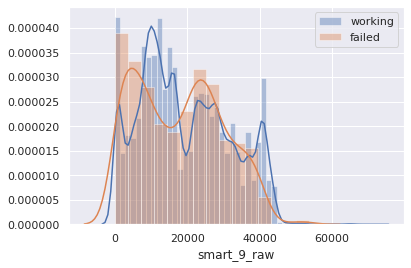

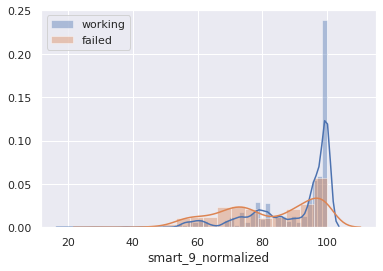

In [91]:
# working and failed plots together
for col in hist_cols:
    # get figure and axes for plotting current column
    fig, ax = plt.subplots()
    
    # plot failed and working onto the axes one by one
    data = working_last_smart9_df[col]
    sns.distplot(data[~data.isna()], ax=ax, label='working')
    data = failed_last_smart9_df[col]
    sns.distplot(data[~data.isna()], ax=ax, label='failed')
    plt.legend()
    plt.show()